In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from dataProcessing import getANSZData, DataProcessing

In [2]:
train_data_many_day_x, train_data_many_day_y, dev_data_many_day_x, dev_data_many_day_y, \
        test_data_many_day_x, test_data_many_day_y = getANSZData(n_days=30, columns=['Temperature'])
pr = DataProcessing(train_data_many_day_x, train_data_many_day_y)
train_data_many_day_x = pr.preprocessInput(train_data_many_day_x)
dev_data_many_day_x = pr.preprocessInput(dev_data_many_day_x)
test_data_many_day_x = pr.preprocessInput(test_data_many_day_x)
train_data_many_day_y = pr.preprocessOutput(train_data_many_day_y)
dev_data_many_day_y = pr.preprocessOutput(dev_data_many_day_y)
test_data_many_day_y = pr.preprocessOutput(test_data_many_day_y)

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from ElapsedTime import ElapsedTime

dropout = 0.5
minL2 = -8
maxL2 = 1
l2Arr = np.logspace(minL2, maxL2, -(minL2-maxL2)+1)
patience = 100
batch_size = 4096
early_stopping=EarlyStopping(patience=patience, restore_best_weights=True, verbose=1)

modelArr = []
hstArr = []
for l2 in l2Arr:
    input_size = train_data_many_day_x.shape[1]
    model = Sequential()
    model.add(Dense(units=input_size, activation='relu', input_dim=input_size, kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=28, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=14, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=7, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_squared_error'])
    with ElapsedTime('training'):
        hst = model.fit(train_data_many_day_x, train_data_many_day_y, validation_data=(dev_data_many_day_x, dev_data_many_day_y),
                  verbose=1, epochs=10000, batch_size=batch_size, callbacks=[early_stopping], shuffle=True)
    hst = hst.history
    modelArr.append(model)
    hstArr.append(hst)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 2655 samples, validate on 387 samples
Epoch 1/10000
2655/2655 [==============================] - 5s 2ms/step - loss: 0.0947 - mean_squared_error: 0.0947 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 2/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 3/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 4/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 5/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0379 - val_mean_squared_error: 0.0378
Epoch 6/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0560 - mean_squared_error: 0.0560 - v

Epoch 50/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0356 - val_mean_squared_error: 0.0355
Epoch 51/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0446 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 52/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0355 - val_mean_squared_error: 0.0354
Epoch 53/10000
2655/2655 [==============================] - 0s 5us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 54/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0354 - val_mean_squared_error: 0.0353
Epoch 55/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0353 - val_mean_squared_error:

Epoch 99/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0407 - mean_squared_error: 0.0406 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 100/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 101/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 102/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 103/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 104/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0317 - val_mean_squared_e

Epoch 148/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 149/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 150/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 151/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 152/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 153/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0240 - val_mean_squared_

Epoch 197/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 198/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0220 - val_mean_squared_error: 0.0219
Epoch 199/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 0.0213 - val_mean_squared_error: 0.0212
Epoch 200/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 201/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 202/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0230 - val_mean_squared_

Epoch 246/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 247/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 248/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 249/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 250/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 251/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0227 - val_mean_squared_

Epoch 295/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 296/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 297/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 298/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 299/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0219 - val_mean_squared_error: 0.0218
Epoch 300/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0227 - val_mean_squared_

Epoch 36/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0454 - mean_squared_error: 0.0453 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 37/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0455 - mean_squared_error: 0.0454 - val_loss: 0.0363 - val_mean_squared_error: 0.0362
Epoch 38/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 39/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0450 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 40/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0452 - mean_squared_error: 0.0451 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 41/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0450 - val_loss: 0.0361 - val_mean_squared_error:

Epoch 85/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0336 - val_mean_squared_error: 0.0335
Epoch 86/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0416 - mean_squared_error: 0.0415 - val_loss: 0.0335 - val_mean_squared_error: 0.0334
Epoch 87/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 88/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0333 - val_mean_squared_error: 0.0332
Epoch 89/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0412 - mean_squared_error: 0.0411 - val_loss: 0.0332 - val_mean_squared_error: 0.0331
Epoch 90/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0330 - val_mean_squared_error:

Epoch 134/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0360 - mean_squared_error: 0.0359 - val_loss: 0.0254 - val_mean_squared_error: 0.0253
Epoch 135/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0353 - mean_squared_error: 0.0352 - val_loss: 0.0252 - val_mean_squared_error: 0.0251
Epoch 136/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0354 - mean_squared_error: 0.0353 - val_loss: 0.0255 - val_mean_squared_error: 0.0254
Epoch 137/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0248 - val_mean_squared_error: 0.0247
Epoch 138/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0239 - val_mean_squared_error: 0.0238
Epoch 139/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0233 - val_mean_squared_

Epoch 183/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0317 - mean_squared_error: 0.0316 - val_loss: 0.0200 - val_mean_squared_error: 0.0199
Epoch 184/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0327 - mean_squared_error: 0.0326 - val_loss: 0.0202 - val_mean_squared_error: 0.0201
Epoch 185/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0323 - mean_squared_error: 0.0322 - val_loss: 0.0206 - val_mean_squared_error: 0.0205
Epoch 186/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0318 - mean_squared_error: 0.0317 - val_loss: 0.0206 - val_mean_squared_error: 0.0205
Epoch 187/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0206 - val_mean_squared_error: 0.0205
Epoch 188/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0317 - mean_squared_error: 0.0316 - val_loss: 0.0202 - val_mean_squared_

Epoch 232/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0304 - mean_squared_error: 0.0303 - val_loss: 0.0200 - val_mean_squared_error: 0.0199
Epoch 233/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0304 - mean_squared_error: 0.0303 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 234/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0304 - mean_squared_error: 0.0303 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 235/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0306 - mean_squared_error: 0.0305 - val_loss: 0.0224 - val_mean_squared_error: 0.0223
Epoch 236/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0306 - mean_squared_error: 0.0305 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 237/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0310 - mean_squared_error: 0.0309 - val_loss: 0.0217 - val_mean_squared_

Epoch 281/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0211 - val_mean_squared_error: 0.0210
Epoch 282/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0301 - mean_squared_error: 0.0300 - val_loss: 0.0219 - val_mean_squared_error: 0.0218
Epoch 283/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 284/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0295 - mean_squared_error: 0.0294 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 285/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0297 - mean_squared_error: 0.0296 - val_loss: 0.0227 - val_mean_squared_error: 0.0226
Epoch 286/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0288 - mean_squared_error: 0.0287 - val_loss: 0.0220 - val_mean_squared_

Epoch 14/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0470 - mean_squared_error: 0.0463 - val_loss: 0.0382 - val_mean_squared_error: 0.0375
Epoch 15/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0467 - mean_squared_error: 0.0460 - val_loss: 0.0381 - val_mean_squared_error: 0.0374
Epoch 16/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0465 - mean_squared_error: 0.0458 - val_loss: 0.0380 - val_mean_squared_error: 0.0374
Epoch 17/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0457 - val_loss: 0.0380 - val_mean_squared_error: 0.0373
Epoch 18/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0465 - mean_squared_error: 0.0458 - val_loss: 0.0379 - val_mean_squared_error: 0.0373
Epoch 19/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0465 - mean_squared_error: 0.0458 - val_loss: 0.0379 - val_mean_squared_error:

Epoch 63/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0386 - mean_squared_error: 0.0379 - val_loss: 0.0329 - val_mean_squared_error: 0.0322
Epoch 64/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0378 - mean_squared_error: 0.0372 - val_loss: 0.0328 - val_mean_squared_error: 0.0321
Epoch 65/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0388 - mean_squared_error: 0.0381 - val_loss: 0.0329 - val_mean_squared_error: 0.0322
Epoch 66/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0375 - mean_squared_error: 0.0369 - val_loss: 0.0330 - val_mean_squared_error: 0.0323
Epoch 67/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0379 - mean_squared_error: 0.0372 - val_loss: 0.0331 - val_mean_squared_error: 0.0324
Epoch 68/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0380 - mean_squared_error: 0.0373 - val_loss: 0.0332 - val_mean_squared_error:

Epoch 112/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0327 - mean_squared_error: 0.0321 - val_loss: 0.0274 - val_mean_squared_error: 0.0267
Epoch 113/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0328 - mean_squared_error: 0.0321 - val_loss: 0.0264 - val_mean_squared_error: 0.0257
Epoch 114/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0326 - mean_squared_error: 0.0319 - val_loss: 0.0258 - val_mean_squared_error: 0.0251
Epoch 115/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0327 - mean_squared_error: 0.0320 - val_loss: 0.0260 - val_mean_squared_error: 0.0253
Epoch 116/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0323 - mean_squared_error: 0.0317 - val_loss: 0.0264 - val_mean_squared_error: 0.0258
Epoch 117/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0331 - mean_squared_error: 0.0325 - val_loss: 0.0264 - val_mean_squared_

Epoch 161/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0305 - mean_squared_error: 0.0299 - val_loss: 0.0246 - val_mean_squared_error: 0.0239
Epoch 162/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0301 - mean_squared_error: 0.0295 - val_loss: 0.0240 - val_mean_squared_error: 0.0233
Epoch 163/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0312 - mean_squared_error: 0.0305 - val_loss: 0.0233 - val_mean_squared_error: 0.0227
Epoch 164/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0309 - mean_squared_error: 0.0303 - val_loss: 0.0231 - val_mean_squared_error: 0.0225
Epoch 165/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0305 - mean_squared_error: 0.0298 - val_loss: 0.0231 - val_mean_squared_error: 0.0224
Epoch 166/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0308 - mean_squared_error: 0.0302 - val_loss: 0.0236 - val_mean_squared_

Epoch 210/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0288 - mean_squared_error: 0.0282 - val_loss: 0.0220 - val_mean_squared_error: 0.0214
Epoch 211/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0287 - mean_squared_error: 0.0280 - val_loss: 0.0226 - val_mean_squared_error: 0.0219
Epoch 212/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0299 - mean_squared_error: 0.0292 - val_loss: 0.0249 - val_mean_squared_error: 0.0242
Epoch 213/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0290 - mean_squared_error: 0.0284 - val_loss: 0.0272 - val_mean_squared_error: 0.0266
Epoch 214/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0286 - mean_squared_error: 0.0280 - val_loss: 0.0265 - val_mean_squared_error: 0.0259
Epoch 215/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0297 - mean_squared_error: 0.0291 - val_loss: 0.0240 - val_mean_squared_

Epoch 259/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0284 - mean_squared_error: 0.0278 - val_loss: 0.0263 - val_mean_squared_error: 0.0257
Epoch 260/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0284 - mean_squared_error: 0.0277 - val_loss: 0.0260 - val_mean_squared_error: 0.0254
Epoch 261/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0277 - mean_squared_error: 0.0271 - val_loss: 0.0251 - val_mean_squared_error: 0.0244
Epoch 262/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0279 - mean_squared_error: 0.0273 - val_loss: 0.0237 - val_mean_squared_error: 0.0231
Epoch 263/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0286 - mean_squared_error: 0.0280 - val_loss: 0.0233 - val_mean_squared_error: 0.0227
Epoch 264/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0273 - mean_squared_error: 0.0267 - val_loss: 0.0230 - val_mean_squared_

Epoch 308/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0264 - mean_squared_error: 0.0258 - val_loss: 0.0214 - val_mean_squared_error: 0.0208
Epoch 309/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0267 - mean_squared_error: 0.0260 - val_loss: 0.0218 - val_mean_squared_error: 0.0212
Epoch 310/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0274 - mean_squared_error: 0.0267 - val_loss: 0.0235 - val_mean_squared_error: 0.0229
Epoch 311/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0265 - mean_squared_error: 0.0259 - val_loss: 0.0251 - val_mean_squared_error: 0.0245
Epoch 312/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0264 - mean_squared_error: 0.0257 - val_loss: 0.0248 - val_mean_squared_error: 0.0242
Epoch 313/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0267 - mean_squared_error: 0.0261 - val_loss: 0.0232 - val_mean_squared_

Epoch 39/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0504 - mean_squared_error: 0.0440 - val_loss: 0.0424 - val_mean_squared_error: 0.0360
Epoch 40/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0505 - mean_squared_error: 0.0441 - val_loss: 0.0422 - val_mean_squared_error: 0.0358
Epoch 41/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0503 - mean_squared_error: 0.0439 - val_loss: 0.0421 - val_mean_squared_error: 0.0357
Epoch 42/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0504 - mean_squared_error: 0.0441 - val_loss: 0.0419 - val_mean_squared_error: 0.0356
Epoch 43/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0502 - mean_squared_error: 0.0438 - val_loss: 0.0418 - val_mean_squared_error: 0.0355
Epoch 44/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0500 - mean_squared_error: 0.0437 - val_loss: 0.0417 - val_mean_squared_error:

Epoch 88/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0418 - mean_squared_error: 0.0358 - val_loss: 0.0356 - val_mean_squared_error: 0.0296
Epoch 89/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0402 - mean_squared_error: 0.0342 - val_loss: 0.0352 - val_mean_squared_error: 0.0292
Epoch 90/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0408 - mean_squared_error: 0.0348 - val_loss: 0.0349 - val_mean_squared_error: 0.0289
Epoch 91/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0404 - mean_squared_error: 0.0344 - val_loss: 0.0351 - val_mean_squared_error: 0.0291
Epoch 92/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0402 - mean_squared_error: 0.0342 - val_loss: 0.0346 - val_mean_squared_error: 0.0286
Epoch 93/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0401 - mean_squared_error: 0.0341 - val_loss: 0.0339 - val_mean_squared_error:

Epoch 137/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0357 - mean_squared_error: 0.0300 - val_loss: 0.0280 - val_mean_squared_error: 0.0224
Epoch 138/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0355 - mean_squared_error: 0.0299 - val_loss: 0.0274 - val_mean_squared_error: 0.0217
Epoch 139/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0364 - mean_squared_error: 0.0308 - val_loss: 0.0270 - val_mean_squared_error: 0.0214
Epoch 140/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0353 - mean_squared_error: 0.0297 - val_loss: 0.0271 - val_mean_squared_error: 0.0215
Epoch 141/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0354 - mean_squared_error: 0.0298 - val_loss: 0.0270 - val_mean_squared_error: 0.0214
Epoch 142/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0357 - mean_squared_error: 0.0300 - val_loss: 0.0272 - val_mean_squared_

Epoch 186/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0334 - mean_squared_error: 0.0281 - val_loss: 0.0276 - val_mean_squared_error: 0.0223
Epoch 187/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0330 - mean_squared_error: 0.0277 - val_loss: 0.0265 - val_mean_squared_error: 0.0212
Epoch 188/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0337 - mean_squared_error: 0.0284 - val_loss: 0.0255 - val_mean_squared_error: 0.0202
Epoch 189/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0328 - mean_squared_error: 0.0276 - val_loss: 0.0251 - val_mean_squared_error: 0.0198
Epoch 190/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0335 - mean_squared_error: 0.0282 - val_loss: 0.0252 - val_mean_squared_error: 0.0199
Epoch 191/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0330 - mean_squared_error: 0.0277 - val_loss: 0.0252 - val_mean_squared_

Epoch 235/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0319 - mean_squared_error: 0.0269 - val_loss: 0.0260 - val_mean_squared_error: 0.0211
Epoch 236/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0319 - mean_squared_error: 0.0269 - val_loss: 0.0257 - val_mean_squared_error: 0.0208
Epoch 237/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0322 - mean_squared_error: 0.0272 - val_loss: 0.0256 - val_mean_squared_error: 0.0207
Epoch 238/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0322 - mean_squared_error: 0.0273 - val_loss: 0.0258 - val_mean_squared_error: 0.0209
Epoch 239/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0323 - mean_squared_error: 0.0273 - val_loss: 0.0264 - val_mean_squared_error: 0.0214
Epoch 240/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0324 - mean_squared_error: 0.0274 - val_loss: 0.0272 - val_mean_squared_

Epoch 284/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0313 - mean_squared_error: 0.0267 - val_loss: 0.0260 - val_mean_squared_error: 0.0214
Epoch 285/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0303 - mean_squared_error: 0.0257 - val_loss: 0.0257 - val_mean_squared_error: 0.0211
Epoch 286/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0304 - mean_squared_error: 0.0258 - val_loss: 0.0254 - val_mean_squared_error: 0.0207
Epoch 287/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0316 - mean_squared_error: 0.0270 - val_loss: 0.0251 - val_mean_squared_error: 0.0205
Epoch 288/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0302 - mean_squared_error: 0.0256 - val_loss: 0.0248 - val_mean_squared_error: 0.0202
Epoch 289/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0304 - mean_squared_error: 0.0258 - val_loss: 0.0246 - val_mean_squared_

Epoch 2/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1262 - mean_squared_error: 0.0591 - val_loss: 0.1047 - val_mean_squared_error: 0.0379
Epoch 3/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1204 - mean_squared_error: 0.0536 - val_loss: 0.1046 - val_mean_squared_error: 0.0381
Epoch 4/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1183 - mean_squared_error: 0.0518 - val_loss: 0.1042 - val_mean_squared_error: 0.0381
Epoch 5/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1167 - mean_squared_error: 0.0505 - val_loss: 0.1038 - val_mean_squared_error: 0.0380
Epoch 6/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1141 - mean_squared_error: 0.0484 - val_loss: 0.1034 - val_mean_squared_error: 0.0380
Epoch 7/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1139 - mean_squared_error: 0.0485 - val_loss: 0.1030 - val_mean_squared_error: 0.038

Epoch 51/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0879 - mean_squared_error: 0.0414 - val_loss: 0.0801 - val_mean_squared_error: 0.0340
Epoch 52/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0872 - mean_squared_error: 0.0411 - val_loss: 0.0795 - val_mean_squared_error: 0.0338
Epoch 53/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0868 - mean_squared_error: 0.0411 - val_loss: 0.0789 - val_mean_squared_error: 0.0336
Epoch 54/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0862 - mean_squared_error: 0.0409 - val_loss: 0.0782 - val_mean_squared_error: 0.0333
Epoch 55/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0856 - mean_squared_error: 0.0406 - val_loss: 0.0777 - val_mean_squared_error: 0.0331
Epoch 56/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0851 - mean_squared_error: 0.0406 - val_loss: 0.0772 - val_mean_squared_error:

Epoch 100/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0614 - mean_squared_error: 0.0304 - val_loss: 0.0507 - val_mean_squared_error: 0.0200
Epoch 101/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0616 - mean_squared_error: 0.0309 - val_loss: 0.0499 - val_mean_squared_error: 0.0194
Epoch 102/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0612 - mean_squared_error: 0.0308 - val_loss: 0.0505 - val_mean_squared_error: 0.0203
Epoch 103/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0607 - mean_squared_error: 0.0305 - val_loss: 0.0509 - val_mean_squared_error: 0.0209
Epoch 104/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0591 - mean_squared_error: 0.0292 - val_loss: 0.0498 - val_mean_squared_error: 0.0201
Epoch 105/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0595 - mean_squared_error: 0.0299 - val_loss: 0.0482 - val_mean_squared_

Epoch 149/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0482 - mean_squared_error: 0.0275 - val_loss: 0.0378 - val_mean_squared_error: 0.0172
Epoch 150/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0478 - mean_squared_error: 0.0273 - val_loss: 0.0380 - val_mean_squared_error: 0.0176
Epoch 151/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0477 - mean_squared_error: 0.0273 - val_loss: 0.0379 - val_mean_squared_error: 0.0177
Epoch 152/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0475 - mean_squared_error: 0.0273 - val_loss: 0.0373 - val_mean_squared_error: 0.0173
Epoch 153/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0262 - val_loss: 0.0364 - val_mean_squared_error: 0.0165
Epoch 154/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0468 - mean_squared_error: 0.0269 - val_loss: 0.0355 - val_mean_squared_

Epoch 198/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0395 - mean_squared_error: 0.0252 - val_loss: 0.0288 - val_mean_squared_error: 0.0147
Epoch 199/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0402 - mean_squared_error: 0.0261 - val_loss: 0.0289 - val_mean_squared_error: 0.0148
Epoch 200/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0397 - mean_squared_error: 0.0256 - val_loss: 0.0292 - val_mean_squared_error: 0.0152
Epoch 201/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0394 - mean_squared_error: 0.0255 - val_loss: 0.0297 - val_mean_squared_error: 0.0158
Epoch 202/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0385 - mean_squared_error: 0.0247 - val_loss: 0.0293 - val_mean_squared_error: 0.0156
Epoch 203/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0386 - mean_squared_error: 0.0248 - val_loss: 0.0285 - val_mean_squared_

Epoch 247/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0333 - mean_squared_error: 0.0230 - val_loss: 0.0245 - val_mean_squared_error: 0.0144
Epoch 248/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0338 - mean_squared_error: 0.0237 - val_loss: 0.0243 - val_mean_squared_error: 0.0142
Epoch 249/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0337 - mean_squared_error: 0.0236 - val_loss: 0.0237 - val_mean_squared_error: 0.0136
Epoch 250/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0334 - mean_squared_error: 0.0234 - val_loss: 0.0235 - val_mean_squared_error: 0.0135
Epoch 251/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0330 - mean_squared_error: 0.0231 - val_loss: 0.0235 - val_mean_squared_error: 0.0136
Epoch 252/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0333 - mean_squared_error: 0.0234 - val_loss: 0.0237 - val_mean_squared_

Epoch 296/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0300 - mean_squared_error: 0.0223 - val_loss: 0.0209 - val_mean_squared_error: 0.0132
Epoch 297/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0296 - mean_squared_error: 0.0219 - val_loss: 0.0206 - val_mean_squared_error: 0.0130
Epoch 298/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0293 - mean_squared_error: 0.0217 - val_loss: 0.0207 - val_mean_squared_error: 0.0131
Epoch 299/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0297 - mean_squared_error: 0.0221 - val_loss: 0.0212 - val_mean_squared_error: 0.0137
Epoch 300/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0295 - mean_squared_error: 0.0219 - val_loss: 0.0209 - val_mean_squared_error: 0.0134
Epoch 301/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0296 - mean_squared_error: 0.0221 - val_loss: 0.0205 - val_mean_squared_

Epoch 345/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0269 - mean_squared_error: 0.0209 - val_loss: 0.0189 - val_mean_squared_error: 0.0129
Epoch 346/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0274 - mean_squared_error: 0.0213 - val_loss: 0.0187 - val_mean_squared_error: 0.0127
Epoch 347/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0269 - mean_squared_error: 0.0209 - val_loss: 0.0185 - val_mean_squared_error: 0.0125
Epoch 348/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0268 - mean_squared_error: 0.0208 - val_loss: 0.0185 - val_mean_squared_error: 0.0126
Epoch 349/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0270 - mean_squared_error: 0.0210 - val_loss: 0.0187 - val_mean_squared_error: 0.0127
Epoch 350/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0269 - mean_squared_error: 0.0209 - val_loss: 0.0187 - val_mean_squared_

Epoch 394/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0254 - mean_squared_error: 0.0204 - val_loss: 0.0173 - val_mean_squared_error: 0.0123
Epoch 395/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0257 - mean_squared_error: 0.0207 - val_loss: 0.0174 - val_mean_squared_error: 0.0125
Epoch 396/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0258 - mean_squared_error: 0.0209 - val_loss: 0.0176 - val_mean_squared_error: 0.0127
Epoch 397/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0255 - mean_squared_error: 0.0205 - val_loss: 0.0175 - val_mean_squared_error: 0.0126
Epoch 398/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0253 - mean_squared_error: 0.0204 - val_loss: 0.0174 - val_mean_squared_error: 0.0125
Epoch 399/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0255 - mean_squared_error: 0.0207 - val_loss: 0.0172 - val_mean_squared_

Epoch 443/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0240 - mean_squared_error: 0.0198 - val_loss: 0.0161 - val_mean_squared_error: 0.0119
Epoch 444/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0239 - mean_squared_error: 0.0197 - val_loss: 0.0162 - val_mean_squared_error: 0.0120
Epoch 445/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0242 - mean_squared_error: 0.0200 - val_loss: 0.0165 - val_mean_squared_error: 0.0122
Epoch 446/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0246 - mean_squared_error: 0.0204 - val_loss: 0.0164 - val_mean_squared_error: 0.0122
Epoch 447/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0237 - mean_squared_error: 0.0195 - val_loss: 0.0166 - val_mean_squared_error: 0.0124
Epoch 448/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0239 - mean_squared_error: 0.0197 - val_loss: 0.0166 - val_mean_squared_

Epoch 492/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0238 - mean_squared_error: 0.0201 - val_loss: 0.0161 - val_mean_squared_error: 0.0124
Epoch 493/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0234 - mean_squared_error: 0.0197 - val_loss: 0.0157 - val_mean_squared_error: 0.0120
Epoch 494/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0235 - mean_squared_error: 0.0198 - val_loss: 0.0156 - val_mean_squared_error: 0.0119
Epoch 495/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0237 - mean_squared_error: 0.0200 - val_loss: 0.0157 - val_mean_squared_error: 0.0120
Epoch 496/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0233 - mean_squared_error: 0.0196 - val_loss: 0.0165 - val_mean_squared_error: 0.0128
Epoch 497/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0235 - mean_squared_error: 0.0198 - val_loss: 0.0162 - val_mean_squared_

Epoch 541/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0223 - mean_squared_error: 0.0189 - val_loss: 0.0157 - val_mean_squared_error: 0.0123
Epoch 542/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0227 - mean_squared_error: 0.0193 - val_loss: 0.0159 - val_mean_squared_error: 0.0125
Epoch 543/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0233 - mean_squared_error: 0.0199 - val_loss: 0.0160 - val_mean_squared_error: 0.0126
Epoch 544/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0226 - mean_squared_error: 0.0192 - val_loss: 0.0157 - val_mean_squared_error: 0.0123
Epoch 545/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0225 - mean_squared_error: 0.0191 - val_loss: 0.0153 - val_mean_squared_error: 0.0120
Epoch 546/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0225 - mean_squared_error: 0.0191 - val_loss: 0.0150 - val_mean_squared_

Epoch 590/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0223 - mean_squared_error: 0.0192 - val_loss: 0.0152 - val_mean_squared_error: 0.0121
Epoch 591/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0226 - mean_squared_error: 0.0195 - val_loss: 0.0150 - val_mean_squared_error: 0.0119
Epoch 592/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0223 - mean_squared_error: 0.0192 - val_loss: 0.0146 - val_mean_squared_error: 0.0115
Epoch 593/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0227 - mean_squared_error: 0.0196 - val_loss: 0.0146 - val_mean_squared_error: 0.0115
Epoch 594/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0222 - mean_squared_error: 0.0191 - val_loss: 0.0149 - val_mean_squared_error: 0.0118
Epoch 595/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0222 - mean_squared_error: 0.0191 - val_loss: 0.0155 - val_mean_squared_

Epoch 639/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0225 - mean_squared_error: 0.0196 - val_loss: 0.0144 - val_mean_squared_error: 0.0115
Epoch 640/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0216 - mean_squared_error: 0.0187 - val_loss: 0.0145 - val_mean_squared_error: 0.0116
Epoch 641/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0216 - mean_squared_error: 0.0187 - val_loss: 0.0147 - val_mean_squared_error: 0.0118
Epoch 642/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0220 - mean_squared_error: 0.0191 - val_loss: 0.0154 - val_mean_squared_error: 0.0125
Epoch 643/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0216 - mean_squared_error: 0.0187 - val_loss: 0.0151 - val_mean_squared_error: 0.0122
Epoch 644/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0222 - mean_squared_error: 0.0193 - val_loss: 0.0147 - val_mean_squared_

Epoch 688/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0219 - mean_squared_error: 0.0192 - val_loss: 0.0144 - val_mean_squared_error: 0.0117
Epoch 689/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0212 - mean_squared_error: 0.0185 - val_loss: 0.0142 - val_mean_squared_error: 0.0115
Epoch 690/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0220 - mean_squared_error: 0.0193 - val_loss: 0.0145 - val_mean_squared_error: 0.0118
Epoch 691/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0214 - mean_squared_error: 0.0187 - val_loss: 0.0147 - val_mean_squared_error: 0.0120
Epoch 692/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0214 - mean_squared_error: 0.0187 - val_loss: 0.0156 - val_mean_squared_error: 0.0129
Epoch 693/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0220 - mean_squared_error: 0.0193 - val_loss: 0.0160 - val_mean_squared_

Epoch 737/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0211 - mean_squared_error: 0.0185 - val_loss: 0.0139 - val_mean_squared_error: 0.0113
Epoch 738/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0214 - mean_squared_error: 0.0188 - val_loss: 0.0137 - val_mean_squared_error: 0.0111
Epoch 739/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0222 - mean_squared_error: 0.0196 - val_loss: 0.0138 - val_mean_squared_error: 0.0112
Epoch 740/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0211 - mean_squared_error: 0.0185 - val_loss: 0.0142 - val_mean_squared_error: 0.0116
Epoch 741/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0212 - mean_squared_error: 0.0185 - val_loss: 0.0147 - val_mean_squared_error: 0.0120
Epoch 742/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0215 - mean_squared_error: 0.0189 - val_loss: 0.0151 - val_mean_squared_

Epoch 786/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0217 - mean_squared_error: 0.0191 - val_loss: 0.0144 - val_mean_squared_error: 0.0119
Epoch 787/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0211 - mean_squared_error: 0.0186 - val_loss: 0.0142 - val_mean_squared_error: 0.0117
Epoch 788/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0208 - mean_squared_error: 0.0183 - val_loss: 0.0142 - val_mean_squared_error: 0.0117
Epoch 789/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0212 - mean_squared_error: 0.0187 - val_loss: 0.0143 - val_mean_squared_error: 0.0118
Epoch 790/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0209 - mean_squared_error: 0.0183 - val_loss: 0.0140 - val_mean_squared_error: 0.0115
Epoch 791/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0217 - mean_squared_error: 0.0191 - val_loss: 0.0136 - val_mean_squared_

Epoch 835/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0214 - mean_squared_error: 0.0190 - val_loss: 0.0155 - val_mean_squared_error: 0.0131
Epoch 836/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0223 - mean_squared_error: 0.0199 - val_loss: 0.0154 - val_mean_squared_error: 0.0130
Epoch 837/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0211 - mean_squared_error: 0.0186 - val_loss: 0.0150 - val_mean_squared_error: 0.0126
Epoch 838/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0214 - mean_squared_error: 0.0190 - val_loss: 0.0149 - val_mean_squared_error: 0.0124
Epoch 839/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0215 - mean_squared_error: 0.0191 - val_loss: 0.0154 - val_mean_squared_error: 0.0130
Epoch 840/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0207 - mean_squared_error: 0.0183 - val_loss: 0.0156 - val_mean_squared_

Epoch 884/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0213 - mean_squared_error: 0.0189 - val_loss: 0.0141 - val_mean_squared_error: 0.0117
Epoch 885/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0207 - mean_squared_error: 0.0183 - val_loss: 0.0149 - val_mean_squared_error: 0.0125
Epoch 886/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0209 - mean_squared_error: 0.0185 - val_loss: 0.0146 - val_mean_squared_error: 0.0122
Epoch 887/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0212 - mean_squared_error: 0.0188 - val_loss: 0.0148 - val_mean_squared_error: 0.0125
Epoch 888/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0204 - mean_squared_error: 0.0180 - val_loss: 0.0148 - val_mean_squared_error: 0.0124
Epoch 889/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0206 - mean_squared_error: 0.0182 - val_loss: 0.0144 - val_mean_squared_

Epoch 33/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4593 - mean_squared_error: 0.0459 - val_loss: 0.4429 - val_mean_squared_error: 0.0368
Epoch 34/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4520 - mean_squared_error: 0.0459 - val_loss: 0.4356 - val_mean_squared_error: 0.0367
Epoch 35/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4448 - mean_squared_error: 0.0459 - val_loss: 0.4284 - val_mean_squared_error: 0.0367
Epoch 36/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4376 - mean_squared_error: 0.0458 - val_loss: 0.4214 - val_mean_squared_error: 0.0366
Epoch 37/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4305 - mean_squared_error: 0.0457 - val_loss: 0.4144 - val_mean_squared_error: 0.0366
Epoch 38/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4236 - mean_squared_error: 0.0457 - val_loss: 0.4075 - val_mean_squared_error:

Epoch 82/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2091 - mean_squared_error: 0.0446 - val_loss: 0.1966 - val_mean_squared_error: 0.0353
Epoch 83/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2058 - mean_squared_error: 0.0445 - val_loss: 0.1935 - val_mean_squared_error: 0.0353
Epoch 84/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2030 - mean_squared_error: 0.0448 - val_loss: 0.1905 - val_mean_squared_error: 0.0353
Epoch 85/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1998 - mean_squared_error: 0.0446 - val_loss: 0.1875 - val_mean_squared_error: 0.0353
Epoch 86/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1968 - mean_squared_error: 0.0446 - val_loss: 0.1845 - val_mean_squared_error: 0.0353
Epoch 87/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1940 - mean_squared_error: 0.0447 - val_loss: 0.1817 - val_mean_squared_error:

Epoch 131/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1078 - mean_squared_error: 0.0444 - val_loss: 0.0972 - val_mean_squared_error: 0.0351
Epoch 132/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1064 - mean_squared_error: 0.0443 - val_loss: 0.0960 - val_mean_squared_error: 0.0351
Epoch 133/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1050 - mean_squared_error: 0.0441 - val_loss: 0.0949 - val_mean_squared_error: 0.0351
Epoch 134/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1039 - mean_squared_error: 0.0441 - val_loss: 0.0937 - val_mean_squared_error: 0.0351
Epoch 135/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1027 - mean_squared_error: 0.0441 - val_loss: 0.0926 - val_mean_squared_error: 0.0351
Epoch 136/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1015 - mean_squared_error: 0.0440 - val_loss: 0.0915 - val_mean_squared_

Epoch 180/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0694 - mean_squared_error: 0.0439 - val_loss: 0.0601 - val_mean_squared_error: 0.0350
Epoch 181/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0693 - mean_squared_error: 0.0442 - val_loss: 0.0597 - val_mean_squared_error: 0.0350
Epoch 182/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0686 - mean_squared_error: 0.0439 - val_loss: 0.0593 - val_mean_squared_error: 0.0350
Epoch 183/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0680 - mean_squared_error: 0.0438 - val_loss: 0.0589 - val_mean_squared_error: 0.0350
Epoch 184/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0677 - mean_squared_error: 0.0438 - val_loss: 0.0585 - val_mean_squared_error: 0.0350
Epoch 185/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0676 - mean_squared_error: 0.0441 - val_loss: 0.0581 - val_mean_squared_

Epoch 229/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0555 - mean_squared_error: 0.0438 - val_loss: 0.0466 - val_mean_squared_error: 0.0350
Epoch 230/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0557 - mean_squared_error: 0.0441 - val_loss: 0.0465 - val_mean_squared_error: 0.0350
Epoch 231/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0554 - mean_squared_error: 0.0439 - val_loss: 0.0463 - val_mean_squared_error: 0.0350
Epoch 232/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0553 - mean_squared_error: 0.0440 - val_loss: 0.0462 - val_mean_squared_error: 0.0350
Epoch 233/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0550 - mean_squared_error: 0.0439 - val_loss: 0.0460 - val_mean_squared_error: 0.0350
Epoch 234/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0548 - mean_squared_error: 0.0438 - val_loss: 0.0459 - val_mean_squared_

Epoch 278/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0503 - mean_squared_error: 0.0439 - val_loss: 0.0414 - val_mean_squared_error: 0.0350
Epoch 279/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0504 - mean_squared_error: 0.0440 - val_loss: 0.0413 - val_mean_squared_error: 0.0350
Epoch 280/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0502 - mean_squared_error: 0.0439 - val_loss: 0.0412 - val_mean_squared_error: 0.0350
Epoch 281/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0502 - mean_squared_error: 0.0439 - val_loss: 0.0412 - val_mean_squared_error: 0.0350
Epoch 282/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0502 - mean_squared_error: 0.0440 - val_loss: 0.0411 - val_mean_squared_error: 0.0350
Epoch 283/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0501 - mean_squared_error: 0.0440 - val_loss: 0.0410 - val_mean_squared_

Epoch 327/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0478 - mean_squared_error: 0.0438 - val_loss: 0.0390 - val_mean_squared_error: 0.0350
Epoch 328/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0479 - mean_squared_error: 0.0439 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 329/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0479 - mean_squared_error: 0.0440 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 330/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0477 - mean_squared_error: 0.0438 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 331/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0478 - mean_squared_error: 0.0439 - val_loss: 0.0388 - val_mean_squared_error: 0.0350
Epoch 332/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0478 - mean_squared_error: 0.0439 - val_loss: 0.0388 - val_mean_squared_

Epoch 376/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0466 - mean_squared_error: 0.0440 - val_loss: 0.0377 - val_mean_squared_error: 0.0350
Epoch 377/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0465 - mean_squared_error: 0.0438 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 378/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0464 - mean_squared_error: 0.0438 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 379/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0465 - mean_squared_error: 0.0439 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 380/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0464 - mean_squared_error: 0.0438 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 381/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0464 - mean_squared_error: 0.0438 - val_loss: 0.0376 - val_mean_squared_

Epoch 425/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0456 - mean_squared_error: 0.0437 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 426/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0457 - mean_squared_error: 0.0439 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 427/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0456 - mean_squared_error: 0.0438 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 428/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0457 - mean_squared_error: 0.0439 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 429/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0455 - mean_squared_error: 0.0437 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 430/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0456 - mean_squared_error: 0.0438 - val_loss: 0.0368 - val_mean_squared_

Epoch 474/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0438 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 475/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0449 - mean_squared_error: 0.0436 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 476/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0438 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 477/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0438 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 478/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0438 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 479/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0438 - val_loss: 0.0363 - val_mean_squared_

Epoch 523/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0438 - val_loss: 0.0359 - val_mean_squared_error: 0.0350
Epoch 524/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0359 - val_mean_squared_error: 0.0350
Epoch 525/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0438 - val_loss: 0.0359 - val_mean_squared_error: 0.0350
Epoch 526/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0438 - val_loss: 0.0359 - val_mean_squared_error: 0.0350
Epoch 527/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0359 - val_mean_squared_error: 0.0350
Epoch 528/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0446 - mean_squared_error: 0.0437 - val_loss: 0.0359 - val_mean_squared_

Epoch 572/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 573/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 574/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 575/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0445 - mean_squared_error: 0.0438 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 576/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0445 - mean_squared_error: 0.0438 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 577/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_

Epoch 621/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0438 - val_loss: 0.0355 - val_mean_squared_error: 0.0350
Epoch 622/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0442 - mean_squared_error: 0.0437 - val_loss: 0.0355 - val_mean_squared_error: 0.0350
Epoch 623/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0438 - val_loss: 0.0355 - val_mean_squared_error: 0.0350
Epoch 624/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0442 - mean_squared_error: 0.0437 - val_loss: 0.0355 - val_mean_squared_error: 0.0350
Epoch 625/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0442 - mean_squared_error: 0.0438 - val_loss: 0.0355 - val_mean_squared_error: 0.0350
Epoch 626/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0436 - val_loss: 0.0355 - val_mean_squared_

Epoch 670/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 671/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 672/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 673/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0438 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 674/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 675/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0438 - val_loss: 0.0354 - val_mean_squared_

Epoch 719/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0438 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 720/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 721/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 722/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0438 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 723/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 724/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_

Epoch 768/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 769/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0438 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 770/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 771/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 772/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0438 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 773/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_

Epoch 817/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 818/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 819/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 820/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 821/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 822/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_

Epoch 866/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 867/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 868/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 869/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 870/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 871/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_

Epoch 915/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 916/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 917/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 918/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 919/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 920/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_

Epoch 964/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 965/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 966/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 967/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 968/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 969/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_

Epoch 1013/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1014/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1015/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1016/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1017/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1018/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1062/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1063/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1064/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1065/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1066/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1067/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1111/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1112/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1113/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1114/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1115/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1116/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1160/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1161/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1162/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1163/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1164/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1165/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1209/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1210/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1211/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1212/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1213/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1214/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1258/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1259/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1260/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1261/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1262/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1263/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1307/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1308/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1309/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1310/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1311/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1312/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1356/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1357/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1358/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1359/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1360/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1361/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1405/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1406/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1407/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1408/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1409/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1410/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1454/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1455/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1456/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1457/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1458/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1459/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1503/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1504/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1505/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1506/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1507/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1508/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1552/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1553/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1554/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1555/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1556/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1557/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1601/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1602/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1603/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1604/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1605/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1606/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1650/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1651/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1652/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1653/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1654/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1655/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1699/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1700/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1701/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1702/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1703/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1704/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1748/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1749/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1750/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1751/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1752/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1753/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1797/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1798/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1799/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1800/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1801/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1802/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 13/10000
2655/2655 [==============================] - 0s 7us/step - loss: 5.5301 - mean_squared_error: 0.0476 - val_loss: 5.4174 - val_mean_squared_error: 0.0385
Epoch 14/10000
2655/2655 [==============================] - 0s 7us/step - loss: 5.4268 - mean_squared_error: 0.0479 - val_loss: 5.3152 - val_mean_squared_error: 0.0385
Epoch 15/10000
2655/2655 [==============================] - 0s 6us/step - loss: 5.3250 - mean_squared_error: 0.0483 - val_loss: 5.2144 - val_mean_squared_error: 0.0385
Epoch 16/10000
2655/2655 [==============================] - 0s 6us/step - loss: 5.2233 - mean_squared_error: 0.0474 - val_loss: 5.1150 - val_mean_squared_error: 0.0385
Epoch 17/10000
2655/2655 [==============================] - 0s 6us/step - loss: 5.1233 - mean_squared_error: 0.0467 - val_loss: 5.0171 - val_mean_squared_error: 0.0384
Epoch 18/10000
2655/2655 [==============================] - 0s 7us/step - loss: 5.0256 - mean_squared_error: 0.0470 - val_loss: 4.9206 - val_mean_squared_error:

Epoch 62/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.0700 - mean_squared_error: 0.0452 - val_loss: 2.0189 - val_mean_squared_error: 0.0362
Epoch 63/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.0276 - mean_squared_error: 0.0449 - val_loss: 1.9776 - val_mean_squared_error: 0.0362
Epoch 64/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.9865 - mean_squared_error: 0.0451 - val_loss: 1.9370 - val_mean_squared_error: 0.0361
Epoch 65/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.9457 - mean_squared_error: 0.0448 - val_loss: 1.8973 - val_mean_squared_error: 0.0360
Epoch 66/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1.9062 - mean_squared_error: 0.0449 - val_loss: 1.8584 - val_mean_squared_error: 0.0359
Epoch 67/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.8673 - mean_squared_error: 0.0449 - val_loss: 1.8202 - val_mean_squared_error:

Epoch 111/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7544 - mean_squared_error: 0.0440 - val_loss: 0.7303 - val_mean_squared_error: 0.0350
Epoch 112/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7392 - mean_squared_error: 0.0439 - val_loss: 0.7155 - val_mean_squared_error: 0.0350
Epoch 113/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7245 - mean_squared_error: 0.0440 - val_loss: 0.7010 - val_mean_squared_error: 0.0350
Epoch 114/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7100 - mean_squared_error: 0.0441 - val_loss: 0.6868 - val_mean_squared_error: 0.0350
Epoch 115/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6960 - mean_squared_error: 0.0443 - val_loss: 0.6729 - val_mean_squared_error: 0.0350
Epoch 116/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6818 - mean_squared_error: 0.0439 - val_loss: 0.6593 - val_mean_squared_

Epoch 160/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2969 - mean_squared_error: 0.0441 - val_loss: 0.2827 - val_mean_squared_error: 0.0350
Epoch 161/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.2917 - mean_squared_error: 0.0440 - val_loss: 0.2778 - val_mean_squared_error: 0.0350
Epoch 162/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2868 - mean_squared_error: 0.0440 - val_loss: 0.2730 - val_mean_squared_error: 0.0350
Epoch 163/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2821 - mean_squared_error: 0.0441 - val_loss: 0.2683 - val_mean_squared_error: 0.0350
Epoch 164/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2773 - mean_squared_error: 0.0441 - val_loss: 0.2637 - val_mean_squared_error: 0.0350
Epoch 165/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.2727 - mean_squared_error: 0.0441 - val_loss: 0.2592 - val_mean_squared_

Epoch 209/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1463 - mean_squared_error: 0.0439 - val_loss: 0.1358 - val_mean_squared_error: 0.0350
Epoch 210/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.1447 - mean_squared_error: 0.0439 - val_loss: 0.1342 - val_mean_squared_error: 0.0350
Epoch 211/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1433 - mean_squared_error: 0.0441 - val_loss: 0.1326 - val_mean_squared_error: 0.0350
Epoch 212/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1415 - mean_squared_error: 0.0439 - val_loss: 0.1311 - val_mean_squared_error: 0.0350
Epoch 213/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.1401 - mean_squared_error: 0.0440 - val_loss: 0.1296 - val_mean_squared_error: 0.0350
Epoch 214/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1383 - mean_squared_error: 0.0438 - val_loss: 0.1281 - val_mean_squared_

Epoch 258/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0954 - mean_squared_error: 0.0439 - val_loss: 0.0858 - val_mean_squared_error: 0.0350
Epoch 259/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0948 - mean_squared_error: 0.0439 - val_loss: 0.0852 - val_mean_squared_error: 0.0350
Epoch 260/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0941 - mean_squared_error: 0.0439 - val_loss: 0.0846 - val_mean_squared_error: 0.0350
Epoch 261/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0934 - mean_squared_error: 0.0437 - val_loss: 0.0841 - val_mean_squared_error: 0.0350
Epoch 262/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0930 - mean_squared_error: 0.0439 - val_loss: 0.0835 - val_mean_squared_error: 0.0350
Epoch 263/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0925 - mean_squared_error: 0.0440 - val_loss: 0.0829 - val_mean_squared_

Epoch 307/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0745 - mean_squared_error: 0.0439 - val_loss: 0.0653 - val_mean_squared_error: 0.0350
Epoch 308/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0739 - mean_squared_error: 0.0436 - val_loss: 0.0650 - val_mean_squared_error: 0.0350
Epoch 309/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0739 - mean_squared_error: 0.0439 - val_loss: 0.0648 - val_mean_squared_error: 0.0350
Epoch 310/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0736 - mean_squared_error: 0.0439 - val_loss: 0.0645 - val_mean_squared_error: 0.0350
Epoch 311/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0733 - mean_squared_error: 0.0438 - val_loss: 0.0642 - val_mean_squared_error: 0.0350
Epoch 312/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0730 - mean_squared_error: 0.0438 - val_loss: 0.0639 - val_mean_squared_

Epoch 356/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0635 - mean_squared_error: 0.0438 - val_loss: 0.0545 - val_mean_squared_error: 0.0350
Epoch 357/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0634 - mean_squared_error: 0.0439 - val_loss: 0.0544 - val_mean_squared_error: 0.0350
Epoch 358/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0632 - mean_squared_error: 0.0438 - val_loss: 0.0542 - val_mean_squared_error: 0.0350
Epoch 359/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0629 - mean_squared_error: 0.0437 - val_loss: 0.0540 - val_mean_squared_error: 0.0350
Epoch 360/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0628 - mean_squared_error: 0.0438 - val_loss: 0.0539 - val_mean_squared_error: 0.0350
Epoch 361/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0627 - mean_squared_error: 0.0438 - val_loss: 0.0537 - val_mean_squared_

Epoch 405/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0569 - mean_squared_error: 0.0439 - val_loss: 0.0479 - val_mean_squared_error: 0.0350
Epoch 406/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0567 - mean_squared_error: 0.0438 - val_loss: 0.0478 - val_mean_squared_error: 0.0350
Epoch 407/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0567 - mean_squared_error: 0.0439 - val_loss: 0.0477 - val_mean_squared_error: 0.0350
Epoch 408/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0564 - mean_squared_error: 0.0438 - val_loss: 0.0476 - val_mean_squared_error: 0.0350
Epoch 409/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0564 - mean_squared_error: 0.0438 - val_loss: 0.0475 - val_mean_squared_error: 0.0350
Epoch 410/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0562 - mean_squared_error: 0.0438 - val_loss: 0.0474 - val_mean_squared_

Epoch 454/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0524 - mean_squared_error: 0.0438 - val_loss: 0.0435 - val_mean_squared_error: 0.0350
Epoch 455/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0522 - mean_squared_error: 0.0437 - val_loss: 0.0435 - val_mean_squared_error: 0.0350
Epoch 456/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0521 - mean_squared_error: 0.0437 - val_loss: 0.0434 - val_mean_squared_error: 0.0350
Epoch 457/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0522 - mean_squared_error: 0.0438 - val_loss: 0.0433 - val_mean_squared_error: 0.0350
Epoch 458/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0522 - mean_squared_error: 0.0439 - val_loss: 0.0432 - val_mean_squared_error: 0.0350
Epoch 459/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0519 - mean_squared_error: 0.0437 - val_loss: 0.0432 - val_mean_squared_

Epoch 503/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0494 - mean_squared_error: 0.0438 - val_loss: 0.0406 - val_mean_squared_error: 0.0350
Epoch 504/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0493 - mean_squared_error: 0.0437 - val_loss: 0.0406 - val_mean_squared_error: 0.0350
Epoch 505/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0493 - mean_squared_error: 0.0437 - val_loss: 0.0405 - val_mean_squared_error: 0.0350
Epoch 506/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0493 - mean_squared_error: 0.0438 - val_loss: 0.0405 - val_mean_squared_error: 0.0350
Epoch 507/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0493 - mean_squared_error: 0.0439 - val_loss: 0.0404 - val_mean_squared_error: 0.0350
Epoch 508/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0492 - mean_squared_error: 0.0438 - val_loss: 0.0404 - val_mean_squared_

Epoch 552/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0476 - mean_squared_error: 0.0439 - val_loss: 0.0387 - val_mean_squared_error: 0.0350
Epoch 553/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0474 - mean_squared_error: 0.0438 - val_loss: 0.0387 - val_mean_squared_error: 0.0350
Epoch 554/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0474 - mean_squared_error: 0.0437 - val_loss: 0.0386 - val_mean_squared_error: 0.0350
Epoch 555/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0474 - mean_squared_error: 0.0438 - val_loss: 0.0386 - val_mean_squared_error: 0.0350
Epoch 556/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0473 - mean_squared_error: 0.0437 - val_loss: 0.0386 - val_mean_squared_error: 0.0350
Epoch 557/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0472 - mean_squared_error: 0.0437 - val_loss: 0.0385 - val_mean_squared_

Epoch 601/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0461 - mean_squared_error: 0.0437 - val_loss: 0.0374 - val_mean_squared_error: 0.0350
Epoch 602/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0461 - mean_squared_error: 0.0437 - val_loss: 0.0374 - val_mean_squared_error: 0.0350
Epoch 603/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0461 - mean_squared_error: 0.0437 - val_loss: 0.0374 - val_mean_squared_error: 0.0350
Epoch 604/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0462 - mean_squared_error: 0.0439 - val_loss: 0.0374 - val_mean_squared_error: 0.0350
Epoch 605/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0461 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_squared_error: 0.0350
Epoch 606/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0462 - mean_squared_error: 0.0439 - val_loss: 0.0373 - val_mean_squared_

Epoch 650/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0452 - mean_squared_error: 0.0437 - val_loss: 0.0366 - val_mean_squared_error: 0.0350
Epoch 651/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0452 - mean_squared_error: 0.0437 - val_loss: 0.0366 - val_mean_squared_error: 0.0350
Epoch 652/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0453 - mean_squared_error: 0.0437 - val_loss: 0.0365 - val_mean_squared_error: 0.0350
Epoch 653/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0453 - mean_squared_error: 0.0438 - val_loss: 0.0365 - val_mean_squared_error: 0.0350
Epoch 654/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0453 - mean_squared_error: 0.0438 - val_loss: 0.0365 - val_mean_squared_error: 0.0350
Epoch 655/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0453 - mean_squared_error: 0.0438 - val_loss: 0.0365 - val_mean_squared_

Epoch 699/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 700/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0438 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 701/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 702/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 703/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0438 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 704/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0438 - val_loss: 0.0360 - val_mean_squared_

Epoch 748/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0438 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 749/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 750/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 751/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 752/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 753/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_

Epoch 797/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 798/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 799/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 800/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 801/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0442 - mean_squared_error: 0.0438 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 802/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_

Epoch 846/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 847/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 848/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 849/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 850/10000
2655/2655 [==============================] - 0s 10us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared_error: 0.0350
Epoch 851/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0353 - val_mean_squared

Epoch 895/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 896/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 897/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 898/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 899/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 900/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_

Epoch 944/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 945/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 946/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 947/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 948/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 949/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_

Epoch 993/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 994/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 995/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 996/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 997/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 998/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_

Epoch 1042/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1043/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1044/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1045/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1046/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1047/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1091/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1092/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1093/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1094/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1095/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1096/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1140/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1141/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1142/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1143/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1144/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1145/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1189/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1190/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1191/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1192/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1193/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1194/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1238/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1239/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1240/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1241/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1242/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1243/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1287/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1288/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1289/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1290/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1291/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1292/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1336/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1337/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1338/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1339/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1340/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1341/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 4/10000
2655/2655 [==============================] - 0s 6us/step - loss: 64.6052 - mean_squared_error: 0.0710 - val_loss: 63.4620 - val_mean_squared_error: 0.0384
Epoch 5/10000
2655/2655 [==============================] - 0s 6us/step - loss: 63.4896 - mean_squared_error: 0.0660 - val_loss: 62.3438 - val_mean_squared_error: 0.0383
Epoch 6/10000
2655/2655 [==============================] - 0s 6us/step - loss: 62.3727 - mean_squared_error: 0.0672 - val_loss: 61.2258 - val_mean_squared_error: 0.0383
Epoch 7/10000
2655/2655 [==============================] - 0s 6us/step - loss: 61.2510 - mean_squared_error: 0.0635 - val_loss: 60.1125 - val_mean_squared_error: 0.0382
Epoch 8/10000
2655/2655 [==============================] - 0s 6us/step - loss: 60.1373 - mean_squared_error: 0.0630 - val_loss: 59.0070 - val_mean_squared_error: 0.0381
Epoch 9/10000
2655/2655 [==============================] - 0s 6us/step - loss: 59.0281 - mean_squared_error: 0.0592 - val_loss: 57.9115 - val_mean_squared_

Epoch 53/10000
2655/2655 [==============================] - 0s 6us/step - loss: 24.2345 - mean_squared_error: 0.0454 - val_loss: 23.7207 - val_mean_squared_error: 0.0358
Epoch 54/10000
2655/2655 [==============================] - 0s 7us/step - loss: 23.7301 - mean_squared_error: 0.0452 - val_loss: 23.2265 - val_mean_squared_error: 0.0357
Epoch 55/10000
2655/2655 [==============================] - 0s 6us/step - loss: 23.2358 - mean_squared_error: 0.0451 - val_loss: 22.7421 - val_mean_squared_error: 0.0357
Epoch 56/10000
2655/2655 [==============================] - 0s 6us/step - loss: 22.7512 - mean_squared_error: 0.0449 - val_loss: 22.2673 - val_mean_squared_error: 0.0357
Epoch 57/10000
2655/2655 [==============================] - 0s 6us/step - loss: 22.2765 - mean_squared_error: 0.0449 - val_loss: 21.8019 - val_mean_squared_error: 0.0357
Epoch 58/10000
2655/2655 [==============================] - 0s 6us/step - loss: 21.8112 - mean_squared_error: 0.0449 - val_loss: 21.3459 - val_mean_sq

Epoch 102/10000
2655/2655 [==============================] - 0s 6us/step - loss: 8.4799 - mean_squared_error: 0.0442 - val_loss: 8.2890 - val_mean_squared_error: 0.0353
Epoch 103/10000
2655/2655 [==============================] - 0s 6us/step - loss: 8.2984 - mean_squared_error: 0.0446 - val_loss: 8.1110 - val_mean_squared_error: 0.0353
Epoch 104/10000
2655/2655 [==============================] - 0s 6us/step - loss: 8.1204 - mean_squared_error: 0.0446 - val_loss: 7.9368 - val_mean_squared_error: 0.0353
Epoch 105/10000
2655/2655 [==============================] - 0s 6us/step - loss: 7.9460 - mean_squared_error: 0.0445 - val_loss: 7.7663 - val_mean_squared_error: 0.0353
Epoch 106/10000
2655/2655 [==============================] - 0s 6us/step - loss: 7.7753 - mean_squared_error: 0.0442 - val_loss: 7.5995 - val_mean_squared_error: 0.0353
Epoch 107/10000
2655/2655 [==============================] - 0s 6us/step - loss: 7.6090 - mean_squared_error: 0.0447 - val_loss: 7.4363 - val_mean_squared_

Epoch 151/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.9767 - mean_squared_error: 0.0446 - val_loss: 2.9065 - val_mean_squared_error: 0.0351
Epoch 152/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.9159 - mean_squared_error: 0.0445 - val_loss: 2.8472 - val_mean_squared_error: 0.0351
Epoch 153/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.8565 - mean_squared_error: 0.0444 - val_loss: 2.7893 - val_mean_squared_error: 0.0351
Epoch 154/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.7985 - mean_squared_error: 0.0443 - val_loss: 2.7326 - val_mean_squared_error: 0.0351
Epoch 155/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.7418 - mean_squared_error: 0.0443 - val_loss: 2.6773 - val_mean_squared_error: 0.0351
Epoch 156/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.6864 - mean_squared_error: 0.0442 - val_loss: 2.6232 - val_mean_squared_

Epoch 200/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1770 - mean_squared_error: 0.0441 - val_loss: 1.1484 - val_mean_squared_error: 0.0350
Epoch 201/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1.1575 - mean_squared_error: 0.0441 - val_loss: 1.1293 - val_mean_squared_error: 0.0350
Epoch 202/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1381 - mean_squared_error: 0.0439 - val_loss: 1.1106 - val_mean_squared_error: 0.0350
Epoch 203/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1196 - mean_squared_error: 0.0441 - val_loss: 1.0923 - val_mean_squared_error: 0.0350
Epoch 204/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1.1012 - mean_squared_error: 0.0439 - val_loss: 1.0744 - val_mean_squared_error: 0.0350
Epoch 205/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1.0834 - mean_squared_error: 0.0440 - val_loss: 1.0569 - val_mean_squared_

Epoch 249/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5819 - mean_squared_error: 0.0438 - val_loss: 0.5662 - val_mean_squared_error: 0.0350
Epoch 250/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5752 - mean_squared_error: 0.0440 - val_loss: 0.5594 - val_mean_squared_error: 0.0350
Epoch 251/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5681 - mean_squared_error: 0.0437 - val_loss: 0.5527 - val_mean_squared_error: 0.0350
Epoch 252/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5618 - mean_squared_error: 0.0441 - val_loss: 0.5461 - val_mean_squared_error: 0.0350
Epoch 253/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5551 - mean_squared_error: 0.0440 - val_loss: 0.5397 - val_mean_squared_error: 0.0350
Epoch 254/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5485 - mean_squared_error: 0.0438 - val_loss: 0.5334 - val_mean_squared_

Epoch 298/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.3510 - mean_squared_error: 0.0438 - val_loss: 0.3391 - val_mean_squared_error: 0.0350
Epoch 299/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.3483 - mean_squared_error: 0.0441 - val_loss: 0.3361 - val_mean_squared_error: 0.0350
Epoch 300/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.3448 - mean_squared_error: 0.0437 - val_loss: 0.3330 - val_mean_squared_error: 0.0350
Epoch 301/10000
2655/2655 [==============================] - 0s 20us/step - loss: 0.3420 - mean_squared_error: 0.0440 - val_loss: 0.3300 - val_mean_squared_error: 0.0350
Epoch 302/10000
2655/2655 [==============================] - 0s 11us/step - loss: 0.3390 - mean_squared_error: 0.0440 - val_loss: 0.3271 - val_mean_squared_error: 0.0350
Epoch 303/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.3359 - mean_squared_error: 0.0438 - val_loss: 0.3242 - val_mean_square

Epoch 347/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2362 - mean_squared_error: 0.0439 - val_loss: 0.2255 - val_mean_squared_error: 0.0350
Epoch 348/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2343 - mean_squared_error: 0.0438 - val_loss: 0.2238 - val_mean_squared_error: 0.0350
Epoch 349/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2326 - mean_squared_error: 0.0439 - val_loss: 0.2221 - val_mean_squared_error: 0.0350
Epoch 350/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2309 - mean_squared_error: 0.0439 - val_loss: 0.2204 - val_mean_squared_error: 0.0350
Epoch 351/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2292 - mean_squared_error: 0.0439 - val_loss: 0.2187 - val_mean_squared_error: 0.0350
Epoch 352/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.2277 - mean_squared_error: 0.0440 - val_loss: 0.2170 - val_mean_squared_

Epoch 396/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1675 - mean_squared_error: 0.0437 - val_loss: 0.1577 - val_mean_squared_error: 0.0350
Epoch 397/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1665 - mean_squared_error: 0.0438 - val_loss: 0.1566 - val_mean_squared_error: 0.0350
Epoch 398/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1653 - mean_squared_error: 0.0437 - val_loss: 0.1555 - val_mean_squared_error: 0.0350
Epoch 399/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1645 - mean_squared_error: 0.0439 - val_loss: 0.1545 - val_mean_squared_error: 0.0350
Epoch 400/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1632 - mean_squared_error: 0.0437 - val_loss: 0.1534 - val_mean_squared_error: 0.0350
Epoch 401/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1622 - mean_squared_error: 0.0438 - val_loss: 0.1524 - val_mean_squared_

Epoch 445/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1239 - mean_squared_error: 0.0439 - val_loss: 0.1143 - val_mean_squared_error: 0.0350
Epoch 446/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1231 - mean_squared_error: 0.0438 - val_loss: 0.1136 - val_mean_squared_error: 0.0350
Epoch 447/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1223 - mean_squared_error: 0.0437 - val_loss: 0.1129 - val_mean_squared_error: 0.0350
Epoch 448/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1218 - mean_squared_error: 0.0439 - val_loss: 0.1122 - val_mean_squared_error: 0.0350
Epoch 449/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1211 - mean_squared_error: 0.0439 - val_loss: 0.1115 - val_mean_squared_error: 0.0350
Epoch 450/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1203 - mean_squared_error: 0.0438 - val_loss: 0.1108 - val_mean_squared_

Epoch 494/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0952 - mean_squared_error: 0.0437 - val_loss: 0.0860 - val_mean_squared_error: 0.0350
Epoch 495/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0947 - mean_squared_error: 0.0437 - val_loss: 0.0856 - val_mean_squared_error: 0.0350
Epoch 496/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0944 - mean_squared_error: 0.0438 - val_loss: 0.0851 - val_mean_squared_error: 0.0350
Epoch 497/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0938 - mean_squared_error: 0.0437 - val_loss: 0.0847 - val_mean_squared_error: 0.0350
Epoch 498/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0934 - mean_squared_error: 0.0438 - val_loss: 0.0842 - val_mean_squared_error: 0.0350
Epoch 499/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0930 - mean_squared_error: 0.0438 - val_loss: 0.0838 - val_mean_squared_

Epoch 543/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0768 - mean_squared_error: 0.0439 - val_loss: 0.0676 - val_mean_squared_error: 0.0350
Epoch 544/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0763 - mean_squared_error: 0.0438 - val_loss: 0.0673 - val_mean_squared_error: 0.0350
Epoch 545/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0760 - mean_squared_error: 0.0437 - val_loss: 0.0670 - val_mean_squared_error: 0.0350
Epoch 546/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0757 - mean_squared_error: 0.0437 - val_loss: 0.0667 - val_mean_squared_error: 0.0350
Epoch 547/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0754 - mean_squared_error: 0.0437 - val_loss: 0.0664 - val_mean_squared_error: 0.0350
Epoch 548/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0752 - mean_squared_error: 0.0438 - val_loss: 0.0661 - val_mean_squared_

Epoch 592/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0646 - mean_squared_error: 0.0438 - val_loss: 0.0557 - val_mean_squared_error: 0.0350
Epoch 593/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0644 - mean_squared_error: 0.0438 - val_loss: 0.0555 - val_mean_squared_error: 0.0350
Epoch 594/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0642 - mean_squared_error: 0.0438 - val_loss: 0.0553 - val_mean_squared_error: 0.0350
Epoch 595/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0640 - mean_squared_error: 0.0437 - val_loss: 0.0551 - val_mean_squared_error: 0.0350
Epoch 596/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0639 - mean_squared_error: 0.0438 - val_loss: 0.0549 - val_mean_squared_error: 0.0350
Epoch 597/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0636 - mean_squared_error: 0.0437 - val_loss: 0.0547 - val_mean_squared_

Epoch 641/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0569 - mean_squared_error: 0.0438 - val_loss: 0.0480 - val_mean_squared_error: 0.0350
Epoch 642/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0567 - mean_squared_error: 0.0437 - val_loss: 0.0479 - val_mean_squared_error: 0.0350
Epoch 643/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0566 - mean_squared_error: 0.0437 - val_loss: 0.0477 - val_mean_squared_error: 0.0350
Epoch 644/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0565 - mean_squared_error: 0.0438 - val_loss: 0.0476 - val_mean_squared_error: 0.0350
Epoch 645/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0563 - mean_squared_error: 0.0437 - val_loss: 0.0475 - val_mean_squared_error: 0.0350
Epoch 646/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0562 - mean_squared_error: 0.0437 - val_loss: 0.0474 - val_mean_squared_

Epoch 690/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0518 - mean_squared_error: 0.0437 - val_loss: 0.0431 - val_mean_squared_error: 0.0350
Epoch 691/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0517 - mean_squared_error: 0.0437 - val_loss: 0.0430 - val_mean_squared_error: 0.0350
Epoch 692/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0516 - mean_squared_error: 0.0436 - val_loss: 0.0429 - val_mean_squared_error: 0.0350
Epoch 693/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0517 - mean_squared_error: 0.0438 - val_loss: 0.0428 - val_mean_squared_error: 0.0350
Epoch 694/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0516 - mean_squared_error: 0.0437 - val_loss: 0.0428 - val_mean_squared_error: 0.0350
Epoch 695/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0516 - mean_squared_error: 0.0438 - val_loss: 0.0427 - val_mean_squared_

Epoch 739/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0487 - mean_squared_error: 0.0437 - val_loss: 0.0400 - val_mean_squared_error: 0.0350
Epoch 740/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0487 - mean_squared_error: 0.0437 - val_loss: 0.0399 - val_mean_squared_error: 0.0350
Epoch 741/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0487 - mean_squared_error: 0.0437 - val_loss: 0.0399 - val_mean_squared_error: 0.0350
Epoch 742/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0486 - mean_squared_error: 0.0438 - val_loss: 0.0398 - val_mean_squared_error: 0.0350
Epoch 743/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0486 - mean_squared_error: 0.0438 - val_loss: 0.0398 - val_mean_squared_error: 0.0350
Epoch 744/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0485 - mean_squared_error: 0.0437 - val_loss: 0.0397 - val_mean_squared_

Epoch 788/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0468 - mean_squared_error: 0.0437 - val_loss: 0.0380 - val_mean_squared_error: 0.0350
Epoch 789/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0468 - mean_squared_error: 0.0438 - val_loss: 0.0380 - val_mean_squared_error: 0.0350
Epoch 790/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0468 - mean_squared_error: 0.0438 - val_loss: 0.0380 - val_mean_squared_error: 0.0350
Epoch 791/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0467 - mean_squared_error: 0.0437 - val_loss: 0.0379 - val_mean_squared_error: 0.0350
Epoch 792/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0466 - mean_squared_error: 0.0437 - val_loss: 0.0379 - val_mean_squared_error: 0.0350
Epoch 793/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0466 - mean_squared_error: 0.0437 - val_loss: 0.0379 - val_mean_squared_

Epoch 837/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0455 - mean_squared_error: 0.0437 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 838/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0455 - mean_squared_error: 0.0437 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 839/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0454 - mean_squared_error: 0.0436 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 840/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0454 - mean_squared_error: 0.0436 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 841/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0455 - mean_squared_error: 0.0437 - val_loss: 0.0368 - val_mean_squared_error: 0.0350
Epoch 842/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0455 - mean_squared_error: 0.0438 - val_loss: 0.0367 - val_mean_squared_

Epoch 886/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0437 - val_loss: 0.0361 - val_mean_squared_error: 0.0350
Epoch 887/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0437 - val_loss: 0.0361 - val_mean_squared_error: 0.0350
Epoch 888/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0361 - val_mean_squared_error: 0.0350
Epoch 889/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0448 - mean_squared_error: 0.0437 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 890/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0436 - val_loss: 0.0360 - val_mean_squared_error: 0.0350
Epoch 891/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0447 - mean_squared_error: 0.0437 - val_loss: 0.0360 - val_mean_squared_

Epoch 935/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 936/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 937/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 938/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 939/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 940/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0443 - mean_squared_error: 0.0437 - val_loss: 0.0356 - val_mean_squared_

Epoch 984/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 985/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 986/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 987/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 988/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0438 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 989/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0436 - val_loss: 0.0354 - val_mean_squared_

Epoch 1033/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1034/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1035/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1036/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1037/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1038/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_sq

Epoch 1082/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1083/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1084/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1085/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1086/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1087/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1131/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1132/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1133/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1134/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1135/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1136/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1180/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1181/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1182/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1183/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1184/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1185/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1229/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1230/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1231/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1232/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1233/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1234/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1278/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1279/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1280/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1281/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1282/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1283/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1327/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1328/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1329/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1330/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1331/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1332/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1376/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1377/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1378/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1379/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1380/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1381/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1425/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1426/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1427/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1428/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1429/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1430/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1474/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1475/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1476/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1477/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1478/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1479/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1523/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1524/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1525/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1526/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1527/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1528/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 22/10000
2655/2655 [==============================] - 0s 11us/step - loss: 457.5340 - mean_squared_error: 0.0473 - val_loss: 448.4703 - val_mean_squared_error: 0.0375
Epoch 23/10000
2655/2655 [==============================] - 0s 9us/step - loss: 448.4799 - mean_squared_error: 0.0471 - val_loss: 439.5701 - val_mean_squared_error: 0.0375
Epoch 24/10000
2655/2655 [==============================] - 0s 7us/step - loss: 439.5796 - mean_squared_error: 0.0470 - val_loss: 430.8230 - val_mean_squared_error: 0.0374
Epoch 25/10000
2655/2655 [==============================] - 0s 6us/step - loss: 430.8321 - mean_squared_error: 0.0465 - val_loss: 422.2278 - val_mean_squared_error: 0.0374
Epoch 26/10000
2655/2655 [==============================] - 0s 6us/step - loss: 422.2372 - mean_squared_error: 0.0468 - val_loss: 413.7836 - val_mean_squared_error: 0.0373
Epoch 27/10000
2655/2655 [==============================] - 0s 6us/step - loss: 413.7931 - mean_squared_error: 0.0469 - val_loss: 405.4891 

Epoch 70/10000
2655/2655 [==============================] - 0s 6us/step - loss: 168.4641 - mean_squared_error: 0.0446 - val_loss: 164.8875 - val_mean_squared_error: 0.0354
Epoch 71/10000
2655/2655 [==============================] - 0s 6us/step - loss: 164.8970 - mean_squared_error: 0.0448 - val_loss: 161.3928 - val_mean_squared_error: 0.0353
Epoch 72/10000
2655/2655 [==============================] - 0s 6us/step - loss: 161.4021 - mean_squared_error: 0.0446 - val_loss: 157.9694 - val_mean_squared_error: 0.0353
Epoch 73/10000
2655/2655 [==============================] - 0s 6us/step - loss: 157.9786 - mean_squared_error: 0.0445 - val_loss: 154.6159 - val_mean_squared_error: 0.0353
Epoch 74/10000
2655/2655 [==============================] - 0s 6us/step - loss: 154.6251 - mean_squared_error: 0.0445 - val_loss: 151.3310 - val_mean_squared_error: 0.0353
Epoch 75/10000
2655/2655 [==============================] - 0s 7us/step - loss: 151.3402 - mean_squared_error: 0.0445 - val_loss: 148.1134 -

Epoch 118/10000
2655/2655 [==============================] - 0s 6us/step - loss: 59.5174 - mean_squared_error: 0.0440 - val_loss: 58.2285 - val_mean_squared_error: 0.0350
Epoch 119/10000
2655/2655 [==============================] - 0s 6us/step - loss: 58.2377 - mean_squared_error: 0.0443 - val_loss: 56.9766 - val_mean_squared_error: 0.0350
Epoch 120/10000
2655/2655 [==============================] - 0s 6us/step - loss: 56.9857 - mean_squared_error: 0.0441 - val_loss: 55.7521 - val_mean_squared_error: 0.0350
Epoch 121/10000
2655/2655 [==============================] - 0s 7us/step - loss: 55.7614 - mean_squared_error: 0.0443 - val_loss: 54.5546 - val_mean_squared_error: 0.0350
Epoch 122/10000
2655/2655 [==============================] - 0s 6us/step - loss: 54.5636 - mean_squared_error: 0.0440 - val_loss: 53.3835 - val_mean_squared_error: 0.0350
Epoch 123/10000
2655/2655 [==============================] - 0s 6us/step - loss: 53.3928 - mean_squared_error: 0.0443 - val_loss: 52.2382 - val_m

Epoch 166/10000
2655/2655 [==============================] - 0s 6us/step - loss: 21.5760 - mean_squared_error: 0.0436 - val_loss: 21.1389 - val_mean_squared_error: 0.0350
Epoch 167/10000
2655/2655 [==============================] - 0s 6us/step - loss: 21.1479 - mean_squared_error: 0.0440 - val_loss: 20.7202 - val_mean_squared_error: 0.0350
Epoch 168/10000
2655/2655 [==============================] - 0s 6us/step - loss: 20.7292 - mean_squared_error: 0.0440 - val_loss: 20.3111 - val_mean_squared_error: 0.0350
Epoch 169/10000
2655/2655 [==============================] - 0s 6us/step - loss: 20.3200 - mean_squared_error: 0.0439 - val_loss: 19.9114 - val_mean_squared_error: 0.0350
Epoch 170/10000
2655/2655 [==============================] - 0s 6us/step - loss: 19.9204 - mean_squared_error: 0.0440 - val_loss: 19.5209 - val_mean_squared_error: 0.0350
Epoch 171/10000
2655/2655 [==============================] - 0s 9us/step - loss: 19.5297 - mean_squared_error: 0.0439 - val_loss: 19.1393 - val_m

Epoch 214/10000
2655/2655 [==============================] - 0s 7us/step - loss: 9.0048 - mean_squared_error: 0.0438 - val_loss: 8.8532 - val_mean_squared_error: 0.0350
Epoch 215/10000
2655/2655 [==============================] - 0s 6us/step - loss: 8.8620 - mean_squared_error: 0.0438 - val_loss: 8.7135 - val_mean_squared_error: 0.0350
Epoch 216/10000
2655/2655 [==============================] - 0s 6us/step - loss: 8.7223 - mean_squared_error: 0.0438 - val_loss: 8.5768 - val_mean_squared_error: 0.0350
Epoch 217/10000
2655/2655 [==============================] - 0s 7us/step - loss: 8.5855 - mean_squared_error: 0.0437 - val_loss: 8.4431 - val_mean_squared_error: 0.0350
Epoch 218/10000
2655/2655 [==============================] - 0s 8us/step - loss: 8.4520 - mean_squared_error: 0.0439 - val_loss: 8.3123 - val_mean_squared_error: 0.0350
Epoch 219/10000
2655/2655 [==============================] - 0s 9us/step - loss: 8.3213 - mean_squared_error: 0.0440 - val_loss: 8.1843 - val_mean_squared_

Epoch 263/10000
2655/2655 [==============================] - 0s 7us/step - loss: 4.5819 - mean_squared_error: 0.0439 - val_loss: 4.5194 - val_mean_squared_error: 0.0350
Epoch 264/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.5282 - mean_squared_error: 0.0438 - val_loss: 4.4668 - val_mean_squared_error: 0.0350
Epoch 265/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.4758 - mean_squared_error: 0.0440 - val_loss: 4.4151 - val_mean_squared_error: 0.0350
Epoch 266/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.4239 - mean_squared_error: 0.0438 - val_loss: 4.3643 - val_mean_squared_error: 0.0350
Epoch 267/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.3731 - mean_squared_error: 0.0438 - val_loss: 4.3144 - val_mean_squared_error: 0.0350
Epoch 268/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.3233 - mean_squared_error: 0.0439 - val_loss: 4.2653 - val_mean_squared_

Epoch 312/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.7437 - mean_squared_error: 0.0436 - val_loss: 2.7092 - val_mean_squared_error: 0.0350
Epoch 313/10000
2655/2655 [==============================] - 0s 7us/step - loss: 2.7182 - mean_squared_error: 0.0439 - val_loss: 2.6837 - val_mean_squared_error: 0.0350
Epoch 314/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.6924 - mean_squared_error: 0.0437 - val_loss: 2.6585 - val_mean_squared_error: 0.0350
Epoch 315/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.6673 - mean_squared_error: 0.0438 - val_loss: 2.6336 - val_mean_squared_error: 0.0350
Epoch 316/10000
2655/2655 [==============================] - 0s 7us/step - loss: 2.6423 - mean_squared_error: 0.0438 - val_loss: 2.6090 - val_mean_squared_error: 0.0350
Epoch 317/10000
2655/2655 [==============================] - 0s 7us/step - loss: 2.6176 - mean_squared_error: 0.0437 - val_loss: 2.5847 - val_mean_squared_

Epoch 361/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.7670 - mean_squared_error: 0.0438 - val_loss: 1.7430 - val_mean_squared_error: 0.0350
Epoch 362/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.7517 - mean_squared_error: 0.0437 - val_loss: 1.7279 - val_mean_squared_error: 0.0350
Epoch 363/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.7367 - mean_squared_error: 0.0438 - val_loss: 1.7130 - val_mean_squared_error: 0.0350
Epoch 364/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.7217 - mean_squared_error: 0.0437 - val_loss: 1.6983 - val_mean_squared_error: 0.0350
Epoch 365/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.7070 - mean_squared_error: 0.0438 - val_loss: 1.6836 - val_mean_squared_error: 0.0350
Epoch 366/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.6924 - mean_squared_error: 0.0438 - val_loss: 1.6691 - val_mean_squared_

Epoch 410/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1655 - mean_squared_error: 0.0438 - val_loss: 1.1470 - val_mean_squared_error: 0.0350
Epoch 411/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1558 - mean_squared_error: 0.0438 - val_loss: 1.1374 - val_mean_squared_error: 0.0350
Epoch 412/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1463 - mean_squared_error: 0.0439 - val_loss: 1.1278 - val_mean_squared_error: 0.0350
Epoch 413/10000
2655/2655 [==============================] - 0s 9us/step - loss: 1.1364 - mean_squared_error: 0.0436 - val_loss: 1.1183 - val_mean_squared_error: 0.0350
Epoch 414/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1271 - mean_squared_error: 0.0438 - val_loss: 1.1089 - val_mean_squared_error: 0.0350
Epoch 415/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.1177 - mean_squared_error: 0.0437 - val_loss: 1.0996 - val_mean_squared_

Epoch 459/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7753 - mean_squared_error: 0.0437 - val_loss: 0.7602 - val_mean_squared_error: 0.0350
Epoch 460/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7689 - mean_squared_error: 0.0437 - val_loss: 0.7539 - val_mean_squared_error: 0.0350
Epoch 461/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7626 - mean_squared_error: 0.0437 - val_loss: 0.7476 - val_mean_squared_error: 0.0350
Epoch 462/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7563 - mean_squared_error: 0.0437 - val_loss: 0.7414 - val_mean_squared_error: 0.0350
Epoch 463/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7501 - mean_squared_error: 0.0437 - val_loss: 0.7352 - val_mean_squared_error: 0.0350
Epoch 464/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.7439 - mean_squared_error: 0.0437 - val_loss: 0.7291 - val_mean_squared_

Epoch 508/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5192 - mean_squared_error: 0.0438 - val_loss: 0.5063 - val_mean_squared_error: 0.0350
Epoch 509/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5150 - mean_squared_error: 0.0438 - val_loss: 0.5021 - val_mean_squared_error: 0.0350
Epoch 510/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5108 - mean_squared_error: 0.0437 - val_loss: 0.4980 - val_mean_squared_error: 0.0350
Epoch 511/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.5067 - mean_squared_error: 0.0438 - val_loss: 0.4939 - val_mean_squared_error: 0.0350
Epoch 512/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.5026 - mean_squared_error: 0.0437 - val_loss: 0.4899 - val_mean_squared_error: 0.0350
Epoch 513/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4985 - mean_squared_error: 0.0437 - val_loss: 0.4859 - val_mean_squared_

Epoch 557/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3511 - mean_squared_error: 0.0437 - val_loss: 0.3397 - val_mean_squared_error: 0.0350
Epoch 558/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3484 - mean_squared_error: 0.0437 - val_loss: 0.3370 - val_mean_squared_error: 0.0350
Epoch 559/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3457 - mean_squared_error: 0.0437 - val_loss: 0.3343 - val_mean_squared_error: 0.0350
Epoch 560/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3431 - mean_squared_error: 0.0438 - val_loss: 0.3316 - val_mean_squared_error: 0.0350
Epoch 561/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3403 - mean_squared_error: 0.0437 - val_loss: 0.3290 - val_mean_squared_error: 0.0350
Epoch 562/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.3377 - mean_squared_error: 0.0437 - val_loss: 0.3264 - val_mean_squared_

Epoch 606/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2414 - mean_squared_error: 0.0437 - val_loss: 0.2309 - val_mean_squared_error: 0.0350
Epoch 607/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2396 - mean_squared_error: 0.0438 - val_loss: 0.2291 - val_mean_squared_error: 0.0350
Epoch 608/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2378 - mean_squared_error: 0.0437 - val_loss: 0.2274 - val_mean_squared_error: 0.0350
Epoch 609/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2361 - mean_squared_error: 0.0437 - val_loss: 0.2256 - val_mean_squared_error: 0.0350
Epoch 610/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2343 - mean_squared_error: 0.0437 - val_loss: 0.2239 - val_mean_squared_error: 0.0350
Epoch 611/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2326 - mean_squared_error: 0.0437 - val_loss: 0.2222 - val_mean_squared_

Epoch 655/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1699 - mean_squared_error: 0.0437 - val_loss: 0.1601 - val_mean_squared_error: 0.0350
Epoch 656/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1688 - mean_squared_error: 0.0437 - val_loss: 0.1590 - val_mean_squared_error: 0.0350
Epoch 657/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1676 - mean_squared_error: 0.0437 - val_loss: 0.1578 - val_mean_squared_error: 0.0350
Epoch 658/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1665 - mean_squared_error: 0.0437 - val_loss: 0.1567 - val_mean_squared_error: 0.0350
Epoch 659/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1654 - mean_squared_error: 0.0437 - val_loss: 0.1556 - val_mean_squared_error: 0.0350
Epoch 660/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1643 - mean_squared_error: 0.0437 - val_loss: 0.1545 - val_mean_squared_

Epoch 704/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1237 - mean_squared_error: 0.0437 - val_loss: 0.1143 - val_mean_squared_error: 0.0350
Epoch 705/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1229 - mean_squared_error: 0.0437 - val_loss: 0.1135 - val_mean_squared_error: 0.0350
Epoch 706/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1222 - mean_squared_error: 0.0437 - val_loss: 0.1128 - val_mean_squared_error: 0.0350
Epoch 707/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1215 - mean_squared_error: 0.0437 - val_loss: 0.1121 - val_mean_squared_error: 0.0350
Epoch 708/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.1207 - mean_squared_error: 0.0437 - val_loss: 0.1113 - val_mean_squared_error: 0.0350
Epoch 709/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1200 - mean_squared_error: 0.0437 - val_loss: 0.1106 - val_mean_squared_

Epoch 753/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0939 - mean_squared_error: 0.0437 - val_loss: 0.0848 - val_mean_squared_error: 0.0350
Epoch 754/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0935 - mean_squared_error: 0.0437 - val_loss: 0.0843 - val_mean_squared_error: 0.0350
Epoch 755/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0930 - mean_squared_error: 0.0437 - val_loss: 0.0838 - val_mean_squared_error: 0.0350
Epoch 756/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0925 - mean_squared_error: 0.0437 - val_loss: 0.0834 - val_mean_squared_error: 0.0350
Epoch 757/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0920 - mean_squared_error: 0.0437 - val_loss: 0.0829 - val_mean_squared_error: 0.0350
Epoch 758/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0916 - mean_squared_error: 0.0437 - val_loss: 0.0824 - val_mean_squared_

Epoch 802/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0749 - mean_squared_error: 0.0437 - val_loss: 0.0659 - val_mean_squared_error: 0.0350
Epoch 803/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0746 - mean_squared_error: 0.0437 - val_loss: 0.0656 - val_mean_squared_error: 0.0350
Epoch 804/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0743 - mean_squared_error: 0.0437 - val_loss: 0.0653 - val_mean_squared_error: 0.0350
Epoch 805/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0740 - mean_squared_error: 0.0437 - val_loss: 0.0650 - val_mean_squared_error: 0.0350
Epoch 806/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0737 - mean_squared_error: 0.0437 - val_loss: 0.0647 - val_mean_squared_error: 0.0350
Epoch 807/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0734 - mean_squared_error: 0.0437 - val_loss: 0.0644 - val_mean_squared_

Epoch 851/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0628 - mean_squared_error: 0.0437 - val_loss: 0.0540 - val_mean_squared_error: 0.0350
Epoch 852/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0626 - mean_squared_error: 0.0437 - val_loss: 0.0538 - val_mean_squared_error: 0.0350
Epoch 853/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0625 - mean_squared_error: 0.0437 - val_loss: 0.0536 - val_mean_squared_error: 0.0350
Epoch 854/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0623 - mean_squared_error: 0.0437 - val_loss: 0.0534 - val_mean_squared_error: 0.0350
Epoch 855/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0621 - mean_squared_error: 0.0437 - val_loss: 0.0532 - val_mean_squared_error: 0.0350
Epoch 856/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0619 - mean_squared_error: 0.0437 - val_loss: 0.0530 - val_mean_squared_

Epoch 900/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0553 - mean_squared_error: 0.0437 - val_loss: 0.0465 - val_mean_squared_error: 0.0350
Epoch 901/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0552 - mean_squared_error: 0.0437 - val_loss: 0.0464 - val_mean_squared_error: 0.0350
Epoch 902/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0551 - mean_squared_error: 0.0437 - val_loss: 0.0463 - val_mean_squared_error: 0.0350
Epoch 903/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0549 - mean_squared_error: 0.0437 - val_loss: 0.0461 - val_mean_squared_error: 0.0350
Epoch 904/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0548 - mean_squared_error: 0.0437 - val_loss: 0.0460 - val_mean_squared_error: 0.0350
Epoch 905/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0547 - mean_squared_error: 0.0437 - val_loss: 0.0459 - val_mean_squared_

Epoch 949/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0506 - mean_squared_error: 0.0437 - val_loss: 0.0419 - val_mean_squared_error: 0.0350
Epoch 950/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0505 - mean_squared_error: 0.0437 - val_loss: 0.0418 - val_mean_squared_error: 0.0350
Epoch 951/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0504 - mean_squared_error: 0.0437 - val_loss: 0.0417 - val_mean_squared_error: 0.0350
Epoch 952/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0504 - mean_squared_error: 0.0437 - val_loss: 0.0416 - val_mean_squared_error: 0.0350
Epoch 953/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0503 - mean_squared_error: 0.0437 - val_loss: 0.0416 - val_mean_squared_error: 0.0350
Epoch 954/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0503 - mean_squared_error: 0.0437 - val_loss: 0.0415 - val_mean_squared_

Epoch 998/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0478 - mean_squared_error: 0.0437 - val_loss: 0.0390 - val_mean_squared_error: 0.0350
Epoch 999/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0477 - mean_squared_error: 0.0437 - val_loss: 0.0390 - val_mean_squared_error: 0.0350
Epoch 1000/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0477 - mean_squared_error: 0.0437 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 1001/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0476 - mean_squared_error: 0.0437 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 1002/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0476 - mean_squared_error: 0.0437 - val_loss: 0.0389 - val_mean_squared_error: 0.0350
Epoch 1003/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0475 - mean_squared_error: 0.0437 - val_loss: 0.0388 - val_mean_squa

Epoch 1047/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0460 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_squared_error: 0.0350
Epoch 1048/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0460 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_squared_error: 0.0350
Epoch 1049/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0460 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_squared_error: 0.0350
Epoch 1050/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0460 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_squared_error: 0.0350
Epoch 1051/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0459 - mean_squared_error: 0.0437 - val_loss: 0.0372 - val_mean_squared_error: 0.0350
Epoch 1052/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0459 - mean_squared_error: 0.0437 - val_loss: 0.0372 - val_mean_sq

Epoch 1096/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 1097/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 1098/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 1099/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 1100/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_squared_error: 0.0350
Epoch 1101/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0449 - mean_squared_error: 0.0437 - val_loss: 0.0363 - val_mean_sq

Epoch 1145/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0358 - val_mean_squared_error: 0.0350
Epoch 1146/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1147/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1148/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1149/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1150/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_sq

Epoch 1194/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1195/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1196/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1197/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1198/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1199/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_sq

Epoch 1243/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1244/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1245/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1246/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1247/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1248/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_sq

Epoch 1292/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1293/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1294/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1295/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1296/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1297/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1341/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1342/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1343/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1344/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1345/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1346/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1390/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1391/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1392/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1393/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1394/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1395/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1439/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1440/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1441/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1442/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1443/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1444/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1488/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1489/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1490/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1491/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1492/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1493/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1537/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1538/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1539/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1540/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1541/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1542/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1586/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1587/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1588/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1589/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1590/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1591/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1635/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1636/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1637/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1638/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1639/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1640/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1684/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1685/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1686/10000
2655/2655 [==============================] - 0s 9us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1687/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1688/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1689/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1733/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1734/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1735/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1736/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1737/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1738/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1782/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1783/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1784/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1785/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1786/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1787/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1831/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1832/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1833/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1834/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1835/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1836/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1880/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1881/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1882/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1883/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1884/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1885/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 21/10000
2655/2655 [==============================] - 0s 7us/step - loss: 4660.9575 - mean_squared_error: 0.0480 - val_loss: 4568.9497 - val_mean_squared_error: 0.0377
Epoch 22/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4568.9600 - mean_squared_error: 0.0480 - val_loss: 4478.4941 - val_mean_squared_error: 0.0376
Epoch 23/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4478.5049 - mean_squared_error: 0.0482 - val_loss: 4389.5752 - val_mean_squared_error: 0.0376
Epoch 24/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4389.5854 - mean_squared_error: 0.0478 - val_loss: 4302.1860 - val_mean_squared_error: 0.0376
Epoch 25/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4302.1963 - mean_squared_error: 0.0479 - val_loss: 4216.3149 - val_mean_squared_error: 0.0375
Epoch 26/10000
2655/2655 [==============================] - 0s 7us/step - loss: 4216.3247 - mean_squared_error: 0.0471 - val_loss:

Epoch 69/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1717.5588 - mean_squared_error: 0.0448 - val_loss: 1681.1754 - val_mean_squared_error: 0.0358
Epoch 70/10000
2655/2655 [==============================] - 0s 9us/step - loss: 1681.1844 - mean_squared_error: 0.0447 - val_loss: 1645.5411 - val_mean_squared_error: 0.0357
Epoch 71/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1645.5499 - mean_squared_error: 0.0446 - val_loss: 1610.6323 - val_mean_squared_error: 0.0357
Epoch 72/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1610.6414 - mean_squared_error: 0.0447 - val_loss: 1576.4352 - val_mean_squared_error: 0.0356
Epoch 73/10000
2655/2655 [==============================] - 0s 9us/step - loss: 1576.4445 - mean_squared_error: 0.0448 - val_loss: 1542.9370 - val_mean_squared_error: 0.0356
Epoch 74/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1542.9459 - mean_squared_error: 0.0446 - val_loss:

Epoch 117/10000
2655/2655 [==============================] - 0s 6us/step - loss: 606.0128 - mean_squared_error: 0.0445 - val_loss: 592.9319 - val_mean_squared_error: 0.0351
Epoch 118/10000
2655/2655 [==============================] - 0s 6us/step - loss: 592.9408 - mean_squared_error: 0.0441 - val_loss: 580.1466 - val_mean_squared_error: 0.0351
Epoch 119/10000
2655/2655 [==============================] - 0s 7us/step - loss: 580.1555 - mean_squared_error: 0.0440 - val_loss: 567.6417 - val_mean_squared_error: 0.0351
Epoch 120/10000
2655/2655 [==============================] - 0s 6us/step - loss: 567.6509 - mean_squared_error: 0.0443 - val_loss: 555.4113 - val_mean_squared_error: 0.0351
Epoch 121/10000
2655/2655 [==============================] - 0s 7us/step - loss: 555.4205 - mean_squared_error: 0.0442 - val_loss: 543.4501 - val_mean_squared_error: 0.0351
Epoch 122/10000
2655/2655 [==============================] - 0s 6us/step - loss: 543.4592 - mean_squared_error: 0.0442 - val_loss: 531.

Epoch 165/10000
2655/2655 [==============================] - 0s 7us/step - loss: 218.3003 - mean_squared_error: 0.0439 - val_loss: 213.9083 - val_mean_squared_error: 0.0350
Epoch 166/10000
2655/2655 [==============================] - 0s 10us/step - loss: 213.9173 - mean_squared_error: 0.0440 - val_loss: 209.6256 - val_mean_squared_error: 0.0350
Epoch 167/10000
2655/2655 [==============================] - 0s 9us/step - loss: 209.6347 - mean_squared_error: 0.0442 - val_loss: 205.4411 - val_mean_squared_error: 0.0350
Epoch 168/10000
2655/2655 [==============================] - 0s 8us/step - loss: 205.4499 - mean_squared_error: 0.0439 - val_loss: 201.3526 - val_mean_squared_error: 0.0350
Epoch 169/10000
2655/2655 [==============================] - 0s 8us/step - loss: 201.3616 - mean_squared_error: 0.0440 - val_loss: 197.3578 - val_mean_squared_error: 0.0350
Epoch 170/10000
2655/2655 [==============================] - 0s 9us/step - loss: 197.3668 - mean_squared_error: 0.0440 - val_loss: 193

Epoch 213/10000
2655/2655 [==============================] - 0s 6us/step - loss: 89.6783 - mean_squared_error: 0.0440 - val_loss: 88.2081 - val_mean_squared_error: 0.0350
Epoch 214/10000
2655/2655 [==============================] - 0s 6us/step - loss: 88.2170 - mean_squared_error: 0.0439 - val_loss: 86.7788 - val_mean_squared_error: 0.0350
Epoch 215/10000
2655/2655 [==============================] - 0s 7us/step - loss: 86.7877 - mean_squared_error: 0.0439 - val_loss: 85.3805 - val_mean_squared_error: 0.0350
Epoch 216/10000
2655/2655 [==============================] - 0s 6us/step - loss: 85.3896 - mean_squared_error: 0.0441 - val_loss: 84.0126 - val_mean_squared_error: 0.0350
Epoch 217/10000
2655/2655 [==============================] - 0s 6us/step - loss: 84.0212 - mean_squared_error: 0.0437 - val_loss: 82.6742 - val_mean_squared_error: 0.0350
Epoch 218/10000
2655/2655 [==============================] - 0s 6us/step - loss: 82.6831 - mean_squared_error: 0.0439 - val_loss: 81.3647 - val_m

Epoch 261/10000
2655/2655 [==============================] - 0s 7us/step - loss: 45.0274 - mean_squared_error: 0.0438 - val_loss: 44.4633 - val_mean_squared_error: 0.0350
Epoch 262/10000
2655/2655 [==============================] - 0s 6us/step - loss: 44.4721 - mean_squared_error: 0.0438 - val_loss: 43.9177 - val_mean_squared_error: 0.0350
Epoch 263/10000
2655/2655 [==============================] - 0s 6us/step - loss: 43.9266 - mean_squared_error: 0.0438 - val_loss: 43.3817 - val_mean_squared_error: 0.0350
Epoch 264/10000
2655/2655 [==============================] - 0s 7us/step - loss: 43.3906 - mean_squared_error: 0.0438 - val_loss: 42.8551 - val_mean_squared_error: 0.0350
Epoch 265/10000
2655/2655 [==============================] - 0s 6us/step - loss: 42.8639 - mean_squared_error: 0.0438 - val_loss: 42.3375 - val_mean_squared_error: 0.0350
Epoch 266/10000
2655/2655 [==============================] - 0s 6us/step - loss: 42.3464 - mean_squared_error: 0.0439 - val_loss: 41.8288 - val_m

Epoch 309/10000
2655/2655 [==============================] - 0s 6us/step - loss: 26.3476 - mean_squared_error: 0.0437 - val_loss: 26.0717 - val_mean_squared_error: 0.0350
Epoch 310/10000
2655/2655 [==============================] - 0s 6us/step - loss: 26.0805 - mean_squared_error: 0.0438 - val_loss: 25.8079 - val_mean_squared_error: 0.0350
Epoch 311/10000
2655/2655 [==============================] - 0s 6us/step - loss: 25.8166 - mean_squared_error: 0.0437 - val_loss: 25.5474 - val_mean_squared_error: 0.0350
Epoch 312/10000
2655/2655 [==============================] - 0s 6us/step - loss: 25.5561 - mean_squared_error: 0.0437 - val_loss: 25.2903 - val_mean_squared_error: 0.0350
Epoch 313/10000
2655/2655 [==============================] - 0s 6us/step - loss: 25.2991 - mean_squared_error: 0.0438 - val_loss: 25.0363 - val_mean_squared_error: 0.0350
Epoch 314/10000
2655/2655 [==============================] - 0s 6us/step - loss: 25.0452 - mean_squared_error: 0.0438 - val_loss: 24.7856 - val_m

Epoch 357/10000
2655/2655 [==============================] - 0s 6us/step - loss: 16.5057 - mean_squared_error: 0.0438 - val_loss: 16.3418 - val_mean_squared_error: 0.0350
Epoch 358/10000
2655/2655 [==============================] - 0s 10us/step - loss: 16.3505 - mean_squared_error: 0.0438 - val_loss: 16.1883 - val_mean_squared_error: 0.0350
Epoch 359/10000
2655/2655 [==============================] - 0s 7us/step - loss: 16.1970 - mean_squared_error: 0.0437 - val_loss: 16.0363 - val_mean_squared_error: 0.0350
Epoch 360/10000
2655/2655 [==============================] - 0s 6us/step - loss: 16.0450 - mean_squared_error: 0.0437 - val_loss: 15.8858 - val_mean_squared_error: 0.0350
Epoch 361/10000
2655/2655 [==============================] - 0s 6us/step - loss: 15.8946 - mean_squared_error: 0.0438 - val_loss: 15.7369 - val_mean_squared_error: 0.0350
Epoch 362/10000
2655/2655 [==============================] - 0s 6us/step - loss: 15.7456 - mean_squared_error: 0.0437 - val_loss: 15.5894 - val_

Epoch 405/10000
2655/2655 [==============================] - 0s 6us/step - loss: 10.5376 - mean_squared_error: 0.0438 - val_loss: 10.4313 - val_mean_squared_error: 0.0350
Epoch 406/10000
2655/2655 [==============================] - 0s 6us/step - loss: 10.4400 - mean_squared_error: 0.0438 - val_loss: 10.3345 - val_mean_squared_error: 0.0350
Epoch 407/10000
2655/2655 [==============================] - 0s 6us/step - loss: 10.3433 - mean_squared_error: 0.0438 - val_loss: 10.2387 - val_mean_squared_error: 0.0350
Epoch 408/10000
2655/2655 [==============================] - 0s 7us/step - loss: 10.2474 - mean_squared_error: 0.0437 - val_loss: 10.1437 - val_mean_squared_error: 0.0350
Epoch 409/10000
2655/2655 [==============================] - 0s 7us/step - loss: 10.1525 - mean_squared_error: 0.0437 - val_loss: 10.0496 - val_mean_squared_error: 0.0350
Epoch 410/10000
2655/2655 [==============================] - 0s 6us/step - loss: 10.0585 - mean_squared_error: 0.0438 - val_loss: 9.9564 - val_me

Epoch 454/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.6715 - mean_squared_error: 0.0437 - val_loss: 6.6006 - val_mean_squared_error: 0.0350
Epoch 455/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.6094 - mean_squared_error: 0.0438 - val_loss: 6.5390 - val_mean_squared_error: 0.0350
Epoch 456/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.5478 - mean_squared_error: 0.0438 - val_loss: 6.4780 - val_mean_squared_error: 0.0350
Epoch 457/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.4867 - mean_squared_error: 0.0437 - val_loss: 6.4175 - val_mean_squared_error: 0.0350
Epoch 458/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.4262 - mean_squared_error: 0.0438 - val_loss: 6.3576 - val_mean_squared_error: 0.0350
Epoch 459/10000
2655/2655 [==============================] - 0s 6us/step - loss: 6.3664 - mean_squared_error: 0.0438 - val_loss: 6.2982 - val_mean_squared_

Epoch 503/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.2085 - mean_squared_error: 0.0437 - val_loss: 4.1603 - val_mean_squared_error: 0.0350
Epoch 504/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.1691 - mean_squared_error: 0.0438 - val_loss: 4.1211 - val_mean_squared_error: 0.0350
Epoch 505/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.1297 - mean_squared_error: 0.0436 - val_loss: 4.0823 - val_mean_squared_error: 0.0350
Epoch 506/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.0910 - mean_squared_error: 0.0437 - val_loss: 4.0438 - val_mean_squared_error: 0.0350
Epoch 507/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.0525 - mean_squared_error: 0.0437 - val_loss: 4.0057 - val_mean_squared_error: 0.0350
Epoch 508/10000
2655/2655 [==============================] - 0s 6us/step - loss: 4.0144 - mean_squared_error: 0.0437 - val_loss: 3.9680 - val_mean_squared_

Epoch 552/10000
2655/2655 [==============================] - 0s 8us/step - loss: 2.6458 - mean_squared_error: 0.0437 - val_loss: 2.6120 - val_mean_squared_error: 0.0350
Epoch 553/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.6208 - mean_squared_error: 0.0438 - val_loss: 2.5873 - val_mean_squared_error: 0.0350
Epoch 554/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.5960 - mean_squared_error: 0.0438 - val_loss: 2.5627 - val_mean_squared_error: 0.0350
Epoch 555/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.5714 - mean_squared_error: 0.0437 - val_loss: 2.5384 - val_mean_squared_error: 0.0350
Epoch 556/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.5470 - mean_squared_error: 0.0436 - val_loss: 2.5143 - val_mean_squared_error: 0.0350
Epoch 557/10000
2655/2655 [==============================] - 0s 6us/step - loss: 2.5230 - mean_squared_error: 0.0437 - val_loss: 2.4905 - val_mean_squared_

Epoch 601/10000
2655/2655 [==============================] - 0s 9us/step - loss: 1.6606 - mean_squared_error: 0.0438 - val_loss: 1.6361 - val_mean_squared_error: 0.0350
Epoch 602/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1.6448 - mean_squared_error: 0.0437 - val_loss: 1.6205 - val_mean_squared_error: 0.0350
Epoch 603/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1.6292 - mean_squared_error: 0.0437 - val_loss: 1.6051 - val_mean_squared_error: 0.0350
Epoch 604/10000
2655/2655 [==============================] - 0s 9us/step - loss: 1.6138 - mean_squared_error: 0.0437 - val_loss: 1.5899 - val_mean_squared_error: 0.0350
Epoch 605/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1.5986 - mean_squared_error: 0.0437 - val_loss: 1.5747 - val_mean_squared_error: 0.0350
Epoch 606/10000
2655/2655 [==============================] - 0s 8us/step - loss: 1.5834 - mean_squared_error: 0.0437 - val_loss: 1.5598 - val_mean_squared_

Epoch 650/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1.0432 - mean_squared_error: 0.0438 - val_loss: 1.0246 - val_mean_squared_error: 0.0350
Epoch 651/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.0333 - mean_squared_error: 0.0437 - val_loss: 1.0149 - val_mean_squared_error: 0.0350
Epoch 652/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.0236 - mean_squared_error: 0.0437 - val_loss: 1.0053 - val_mean_squared_error: 0.0350
Epoch 653/10000
2655/2655 [==============================] - 0s 7us/step - loss: 1.0139 - mean_squared_error: 0.0437 - val_loss: 0.9957 - val_mean_squared_error: 0.0350
Epoch 654/10000
2655/2655 [==============================] - 0s 6us/step - loss: 1.0045 - mean_squared_error: 0.0437 - val_loss: 0.9863 - val_mean_squared_error: 0.0350
Epoch 655/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.9950 - mean_squared_error: 0.0437 - val_loss: 0.9769 - val_mean_squared_

Epoch 699/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6582 - mean_squared_error: 0.0437 - val_loss: 0.6434 - val_mean_squared_error: 0.0350
Epoch 700/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6521 - mean_squared_error: 0.0437 - val_loss: 0.6374 - val_mean_squared_error: 0.0350
Epoch 701/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6461 - mean_squared_error: 0.0437 - val_loss: 0.6314 - val_mean_squared_error: 0.0350
Epoch 702/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6400 - mean_squared_error: 0.0437 - val_loss: 0.6254 - val_mean_squared_error: 0.0350
Epoch 703/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.6341 - mean_squared_error: 0.0437 - val_loss: 0.6196 - val_mean_squared_error: 0.0350
Epoch 704/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.6282 - mean_squared_error: 0.0437 - val_loss: 0.6138 - val_mean_squared_

Epoch 748/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4192 - mean_squared_error: 0.0437 - val_loss: 0.4068 - val_mean_squared_error: 0.0350
Epoch 749/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4155 - mean_squared_error: 0.0437 - val_loss: 0.4030 - val_mean_squared_error: 0.0350
Epoch 750/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4117 - mean_squared_error: 0.0437 - val_loss: 0.3993 - val_mean_squared_error: 0.0350
Epoch 751/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4080 - mean_squared_error: 0.0437 - val_loss: 0.3957 - val_mean_squared_error: 0.0350
Epoch 752/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.4043 - mean_squared_error: 0.0437 - val_loss: 0.3920 - val_mean_squared_error: 0.0350
Epoch 753/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.4007 - mean_squared_error: 0.0437 - val_loss: 0.3884 - val_mean_squared_

Epoch 797/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2716 - mean_squared_error: 0.0437 - val_loss: 0.2606 - val_mean_squared_error: 0.0350
Epoch 798/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2692 - mean_squared_error: 0.0437 - val_loss: 0.2582 - val_mean_squared_error: 0.0350
Epoch 799/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.2669 - mean_squared_error: 0.0437 - val_loss: 0.2560 - val_mean_squared_error: 0.0350
Epoch 800/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.2646 - mean_squared_error: 0.0437 - val_loss: 0.2537 - val_mean_squared_error: 0.0350
Epoch 801/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2624 - mean_squared_error: 0.0437 - val_loss: 0.2515 - val_mean_squared_error: 0.0350
Epoch 802/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.2601 - mean_squared_error: 0.0437 - val_loss: 0.2492 - val_mean_squared_

Epoch 846/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1808 - mean_squared_error: 0.0437 - val_loss: 0.1707 - val_mean_squared_error: 0.0350
Epoch 847/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.1793 - mean_squared_error: 0.0437 - val_loss: 0.1693 - val_mean_squared_error: 0.0350
Epoch 848/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1780 - mean_squared_error: 0.0437 - val_loss: 0.1679 - val_mean_squared_error: 0.0350
Epoch 849/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1765 - mean_squared_error: 0.0437 - val_loss: 0.1665 - val_mean_squared_error: 0.0350
Epoch 850/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1751 - mean_squared_error: 0.0437 - val_loss: 0.1651 - val_mean_squared_error: 0.0350
Epoch 851/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1738 - mean_squared_error: 0.0437 - val_loss: 0.1637 - val_mean_squared_

Epoch 895/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1253 - mean_squared_error: 0.0437 - val_loss: 0.1158 - val_mean_squared_error: 0.0350
Epoch 896/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1245 - mean_squared_error: 0.0437 - val_loss: 0.1149 - val_mean_squared_error: 0.0350
Epoch 897/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1236 - mean_squared_error: 0.0437 - val_loss: 0.1141 - val_mean_squared_error: 0.0350
Epoch 898/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1227 - mean_squared_error: 0.0437 - val_loss: 0.1132 - val_mean_squared_error: 0.0350
Epoch 899/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.1219 - mean_squared_error: 0.0437 - val_loss: 0.1124 - val_mean_squared_error: 0.0350
Epoch 900/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.1211 - mean_squared_error: 0.0437 - val_loss: 0.1116 - val_mean_squared_

Epoch 944/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0917 - mean_squared_error: 0.0437 - val_loss: 0.0825 - val_mean_squared_error: 0.0350
Epoch 945/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0912 - mean_squared_error: 0.0437 - val_loss: 0.0820 - val_mean_squared_error: 0.0350
Epoch 946/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0907 - mean_squared_error: 0.0437 - val_loss: 0.0815 - val_mean_squared_error: 0.0350
Epoch 947/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0902 - mean_squared_error: 0.0437 - val_loss: 0.0810 - val_mean_squared_error: 0.0350
Epoch 948/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0897 - mean_squared_error: 0.0437 - val_loss: 0.0805 - val_mean_squared_error: 0.0350
Epoch 949/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0892 - mean_squared_error: 0.0437 - val_loss: 0.0800 - val_mean_squared_

Epoch 993/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0716 - mean_squared_error: 0.0437 - val_loss: 0.0626 - val_mean_squared_error: 0.0350
Epoch 994/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0713 - mean_squared_error: 0.0437 - val_loss: 0.0623 - val_mean_squared_error: 0.0350
Epoch 995/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0710 - mean_squared_error: 0.0437 - val_loss: 0.0620 - val_mean_squared_error: 0.0350
Epoch 996/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0707 - mean_squared_error: 0.0437 - val_loss: 0.0617 - val_mean_squared_error: 0.0350
Epoch 997/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0704 - mean_squared_error: 0.0437 - val_loss: 0.0614 - val_mean_squared_error: 0.0350
Epoch 998/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0701 - mean_squared_error: 0.0437 - val_loss: 0.0611 - val_mean_squared_

Epoch 1042/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0597 - mean_squared_error: 0.0437 - val_loss: 0.0508 - val_mean_squared_error: 0.0350
Epoch 1043/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0595 - mean_squared_error: 0.0437 - val_loss: 0.0506 - val_mean_squared_error: 0.0350
Epoch 1044/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0593 - mean_squared_error: 0.0437 - val_loss: 0.0504 - val_mean_squared_error: 0.0350
Epoch 1045/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0591 - mean_squared_error: 0.0437 - val_loss: 0.0503 - val_mean_squared_error: 0.0350
Epoch 1046/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0589 - mean_squared_error: 0.0437 - val_loss: 0.0501 - val_mean_squared_error: 0.0350
Epoch 1047/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0588 - mean_squared_error: 0.0437 - val_loss: 0.0499 - val_mean_sq

Epoch 1091/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0527 - mean_squared_error: 0.0437 - val_loss: 0.0439 - val_mean_squared_error: 0.0350
Epoch 1092/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0526 - mean_squared_error: 0.0437 - val_loss: 0.0438 - val_mean_squared_error: 0.0350
Epoch 1093/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0525 - mean_squared_error: 0.0437 - val_loss: 0.0437 - val_mean_squared_error: 0.0350
Epoch 1094/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0524 - mean_squared_error: 0.0437 - val_loss: 0.0436 - val_mean_squared_error: 0.0350
Epoch 1095/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0523 - mean_squared_error: 0.0437 - val_loss: 0.0435 - val_mean_squared_error: 0.0350
Epoch 1096/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0522 - mean_squared_error: 0.0437 - val_loss: 0.0434 - val_mean_sq

Epoch 1140/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0487 - mean_squared_error: 0.0437 - val_loss: 0.0399 - val_mean_squared_error: 0.0350
Epoch 1141/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0486 - mean_squared_error: 0.0437 - val_loss: 0.0399 - val_mean_squared_error: 0.0350
Epoch 1142/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0486 - mean_squared_error: 0.0437 - val_loss: 0.0398 - val_mean_squared_error: 0.0350
Epoch 1143/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0485 - mean_squared_error: 0.0437 - val_loss: 0.0398 - val_mean_squared_error: 0.0350
Epoch 1144/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0485 - mean_squared_error: 0.0437 - val_loss: 0.0397 - val_mean_squared_error: 0.0350
Epoch 1145/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0484 - mean_squared_error: 0.0437 - val_loss: 0.0397 - val_mean_sq

Epoch 1189/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0464 - mean_squared_error: 0.0437 - val_loss: 0.0377 - val_mean_squared_error: 0.0350
Epoch 1190/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0464 - mean_squared_error: 0.0437 - val_loss: 0.0377 - val_mean_squared_error: 0.0350
Epoch 1191/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0437 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 1192/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0437 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 1193/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0437 - val_loss: 0.0376 - val_mean_squared_error: 0.0350
Epoch 1194/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0462 - mean_squared_error: 0.0437 - val_loss: 0.0375 - val_mean_sq

Epoch 1238/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0365 - val_mean_squared_error: 0.0350
Epoch 1239/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0364 - val_mean_squared_error: 0.0350
Epoch 1240/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0364 - val_mean_squared_error: 0.0350
Epoch 1241/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0364 - val_mean_squared_error: 0.0350
Epoch 1242/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0364 - val_mean_squared_error: 0.0350
Epoch 1243/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0451 - mean_squared_error: 0.0437 - val_loss: 0.0364 - val_mean_sq

Epoch 1287/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0445 - mean_squared_error: 0.0437 - val_loss: 0.0358 - val_mean_squared_error: 0.0350
Epoch 1288/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0358 - val_mean_squared_error: 0.0350
Epoch 1289/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0358 - val_mean_squared_error: 0.0350
Epoch 1290/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1291/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_squared_error: 0.0350
Epoch 1292/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0437 - val_loss: 0.0357 - val_mean_sq

Epoch 1336/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1337/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1338/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1339/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1340/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_squared_error: 0.0350
Epoch 1341/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0441 - mean_squared_error: 0.0437 - val_loss: 0.0354 - val_mean_sq

Epoch 1385/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1386/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1387/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1388/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1389/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_squared_error: 0.0350
Epoch 1390/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0439 - mean_squared_error: 0.0437 - val_loss: 0.0352 - val_mean_sq

Epoch 1434/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1435/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1436/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1437/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1438/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1439/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1483/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1484/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1485/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1486/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1487/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1488/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1532/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1533/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1534/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1535/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1536/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_squared_error: 0.0350
Epoch 1537/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0351 - val_mean_sq

Epoch 1581/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1582/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1583/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1584/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1585/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1586/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1630/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1631/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1632/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1633/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1634/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1635/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1679/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1680/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1681/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1682/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1683/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1684/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1728/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1729/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1730/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1731/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1732/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1733/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1777/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1778/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1779/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1780/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1781/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1782/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1826/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1827/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1828/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1829/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1830/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1831/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1875/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1876/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1877/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1878/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1879/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1880/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1924/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1925/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1926/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1927/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1928/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1929/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 1973/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1974/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1975/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1976/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1977/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 1978/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 2022/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2023/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2024/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2025/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2026/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2027/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

Epoch 2071/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2072/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2073/10000
2655/2655 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2074/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2075/10000
2655/2655 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 2076/10000
2655/2655 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0350 - val_mean_sq

387/387 [==============================] - 0s 8us/step


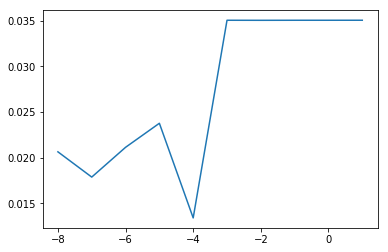

In [4]:
lossIdx = np.argwhere(map(lambda x: x == 'val_loss', model.metrics_names))[0, 0]
lossArr = []
for model in modelArr:
    metrics = model.evaluate(dev_data_many_day_x, dev_data_many_day_y, batch_size=batch_size)
    lossArr.append(metrics[lossIdx])
plt.plot(range(minL2, maxL2+1), lossArr)
plt.show()

Minimal loss is 0.013394307345151901
Minimal l2 regularization is 0.0001


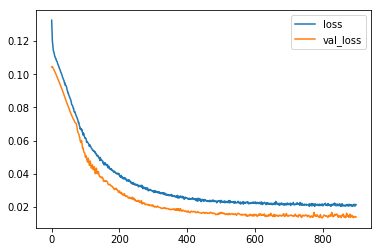

In [5]:
minLoss = np.min(lossArr)
print('Minimal loss is', minLoss)
minLossIdx = np.argmin(lossArr)
print('Minimal l2 regularization is', l2Arr[minLossIdx])
hst = hstArr[minLossIdx]
plt.plot(hst['loss'])
plt.plot(hst['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [6]:
model = modelArr[minLossIdx]

In [13]:
offest = -5
pr.postProcessOutput(model.predict(test_data_many_day_x))[offest:]

array([[13.918863],
       [13.676763],
       [13.490978],
       [13.175695],
       [13.006505]], dtype=float32)

In [14]:
pr.postProcessOutput(test_data_many_day_y)[offest:]

array([[12.09213483],
       [12.66629213],
       [14.81477273],
       [13.81818182],
       [13.26923077]])